# **Load Libraries**

In [ ]:
# !pip install --q optuna
# !pip install --q catboost

In [ ]:
# Utilities
import pandas as pd
import numpy as np
import re
from scipy import stats
pd.set_option('display.max_columns', None)                      # Set the option to display all columns in pandas
pd.set_option('display.max_rows', None)                      # Set the option to display all rows in pandas
np.random.seed(42) # For numpy.random

# Google colab
from google.colab import drive
drive.mount('/content/drive')                                   # Mount the Google Drive in Google Colab

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

# Feature engineering
from sklearn.feature_selection import mutual_info_classif as mic  # Import mutual_info_classif for feature selection
from sklearn.impute import SimpleImputer                          # Import SimpleImputer for missing value imputation
from mlxtend.preprocessing import minmax_scaling
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Modeling
# import optuna                                                   # Import optuna library for hyperparameter optimization
from sklearn.model_selection import KFold                       # Import KFold for cross-validation
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score             # Import cross_val_score for cross-validation
from sklearn.model_selection import GridSearchCV                # Import GridSearchCV for grid search
from sklearn.model_selection import RandomizedSearchCV          # Import RandomizedSearchCV for randomized search
from sklearn.model_selection import learning_curve

# Models
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, BayesianRidge, ElasticNet
from sklearn.ensemble import StackingRegressor
from sklearn import ensemble
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import HuberRegressor
import xgboost as xgb
import lightgbm as lgbm
# import catboost as cb
from sklearn.ensemble import AdaBoostRegressor

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. Data Wrangling**

### **1.1 Load Dataset**

In [ ]:
train_feature = pd.read_csv("/content/drive/MyDrive/DAC-FINDIT/Round2/train_features.csv")
train_label = pd.read_csv("/content/drive/MyDrive/DAC-FINDIT/Round2/train_label.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/DAC-FINDIT/Round2/submission_format.csv", index_col="ID") # Indexnya ID

In [ ]:
# Merge train_feature and train_label
train = train_feature.merge(train_label, left_index=True, right_index=True) # Indexnya not specified
test = pd.read_csv("/content/drive/MyDrive/DAC-FINDIT/Round2/test_feature.csv", index_col="ID") # Indexnya ID

In [ ]:
train.head()

facilities                        rating      location  \
0  RestaurantBARSwimmingPools  7.8 Very GoodFrom 10 reviews        Stokol   
1        intrnetRestaurantgym        5.6 GoodFrom 4 reviews  Machlessvile   
2        restaurantgympoolBar  7.2 Very GoodFrom 38 reviews    Wanderland   
3               BARRestaurant   7.3 Very GoodFrom 6 reviews    Uberlandia   
4          InternetRestaurant  7.2 Very GoodFrom 30 reviews        Stokol   

             Price  
0  13,500avg/night  
1  13,000avg/night  
2  19,000avg/night  
3   6,000avg/night  
4  20,000avg/night

### **1.2 Data Inspection**

In [ ]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (3066, 4)
Test shape: (767, 3)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066 entries, 0 to 3065
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   facilities  2765 non-null   object
 1   rating      2429 non-null   object
 2   location    3066 non-null   object
 3   Price       3066 non-null   object
dtypes: object(4)
memory usage: 95.9+ KB


In [ ]:
def missing_values(train, test):
    miss_perc_df = pd.DataFrame (
        index=['train_miss','test_miss'],
        columns=test.columns,
    )

    for i, col in enumerate(test.columns):
        miss_perc_df.loc['train_miss', col] = np.round(train.isna().sum()[i] / train[col].shape[0] * 100, 2)
        miss_perc_df.loc['test_miss', col] = np.round(test.isna().sum()[i] / test[col].shape[0] * 100, 2)

    miss_perc_df = miss_perc_df.astype(str) + "%"
    return miss_perc_df

In [ ]:
missing_values(train, test)

facilities  rating location
train_miss      9.82%  20.78%     0.0%
test_miss        0.0%    0.0%     0.0%

In [ ]:
# Semuanya msh object
object_cols = train.select_dtypes("object").columns.to_list()
train.loc[:, object_cols].describe()

facilities                       rating location            Price
count         2765                         2429     3066             3066
unique        1138                          311        8              169
top     Restaurant  10.0 ExcellentFrom 1 review   Stokol  20,000avg/night
freq           101                           50      561              228

In [ ]:
object_cols.remove("Price")
print("Object columns:", len(object_cols))

Object columns: 3


In [ ]:
train.loc[train.isna().any(axis=1)].head()

facilities rating      location            Price
8   intrnetbarRestaurant    NaN       Andeman   7,475avg/night
13    internetRestaurant    NaN        Stokol  14,904avg/night
16                   NaN    NaN  Machlessvile   3,200avg/night
17                   BAR    NaN        Stokol  25,000avg/night
25                   bar    NaN    Wanderland   2,500avg/night

- `rating` disini kebanyakan NaN -> berarti tidak ada yg rate dong (logically)
- `facilities` klo NaN -> berarti gaada fasilitas (logically)

### **1.3 Handling Missing Values**
Impute dengan apa (?)

In [ ]:
train["facilities"].mode()

0    Restaurant
Name: facilities, dtype: object

In [ ]:
# INI BAGUS
# Lowerin diawal naikin score soalnya ngaruh ke imputenya
for df in [train, test]:
    df['facilities'] = df['facilities'].str.lower()

train["facilities"].mode()

0    barrestaurant
Name: facilities, dtype: object

In [ ]:
for df in [train, test]:
    # BAGUS BUAT SKOR -> KLO GAPAKE LEARNING CURVE BAGUS
    df['rating'].fillna("", inplace=True)

    # df.dropna(subset=["facilities"], inplace=True) # Facilities
    # df['facilities'].fillna("None", inplace=True);

In [ ]:
imputer = SimpleImputer(strategy='most_frequent')

# Object columns
train[object_cols] = imputer.fit_transform(train[object_cols])
test[object_cols] = imputer.transform(test[object_cols])

In [ ]:
missing_values(train, test)

facilities rating location
train_miss       0.0%   0.0%     0.0%
test_miss        0.0%   0.0%     0.0%

### **1.4 Handling Other Issues**

In [ ]:
# BAGUS
print("Train duplicates:", train.duplicated().sum())
print("Test duplicates:", test.duplicated().sum())
print("Before dropping duplicate", train.shape)

train = train.drop_duplicates()
test = test.drop_duplicates()
print("After dropping duplicate", train.shape)

Train duplicates: 175
Test duplicates: 0
Before dropping duplicate (3066, 4)
After dropping duplicate (2891, 4)


Terlihat bahwa string di facilities klo ada "swimmingpools" -> gaada "pool" (berarti beda?)

In [ ]:
facility_keywords = ['restaurant', 'bar', 'swimmingpools', 'gym', 'internet', 'intrnet', 'pool']

for df in [train, test]:
    for keyword in facility_keywords:
        if keyword == "intrnet":
            df.loc[:, "has_internet"] = df['facilities'].str.contains(keyword)
        else:
            df.loc[:, "has_" + keyword] = df['facilities'].str.contains(keyword)

<ipython-input-498-665619fe50e2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "has_" + keyword] = df['facilities'].str.contains(keyword)
<ipython-input-498-665619fe50e2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "has_" + keyword] = df['facilities'].str.contains(keyword)
<ipython-input-498-665619fe50e2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [ ]:
# # Cek lagi apa ada fasilitas yang lain
# for df in [train, test]:
#     for index, row in df.iterrows():
#         for keyword in facility_keywords:
#             if keyword in df.loc[index, "facilities"]:
#                 df.at[index, "facilities"] = df.loc[index, "facilities"].replace(keyword, "")

In [ ]:
# # Klo output "none" atau "" berarti gada fasilitas lagi yg belum dilist di "facility_keywords"
# print(train["facilities"].unique())
# print(test["facilities"].unique())

In [ ]:
# For now klo has_swimmingpools True -> has_pool False
for df in [train, test]:
    mask = df["has_swimmingpools"] == True
    df.loc[mask, "has_pool"] = False

train[train["has_swimmingpools"] == False].head()

facilities                        rating      location  \
1  intrnetrestaurantgym        5.6 GoodFrom 4 reviews  Machlessvile   
2  restaurantgympoolbar  7.2 Very GoodFrom 38 reviews    Wanderland   
3         barrestaurant   7.3 Very GoodFrom 6 reviews    Uberlandia   
4    internetrestaurant  7.2 Very GoodFrom 30 reviews        Stokol   
5              internet       5.4 GoodFrom 13 reviews    Uberlandia   

             Price  has_restaurant  has_bar  has_swimmingpools  has_gym  \
1  13,000avg/night            True    False              False     True   
2  19,000avg/night            True     True              False     True   
3   6,000avg/night            True     True              False    False   
4  20,000avg/night            True    False              False    False   
5   4,000avg/night           False    False              False    False   

   has_internet  has_pool  
1          True     False  
2         False      True  
3         False     False  
4         False     False  
5         False     False

In [ ]:
# Iterate through each row for "rating"
for df in [train, test]:
    for index, row in df.iterrows():
        current_row = row['rating']
        values = current_row.split('From ')

        # INI NAIKIN SKOR
        if len(values) == 1: # Klo misalnya kosong
            df.at[index, 'num_rating'] = 0.0 # Only numbers
            df.at[index, 'level_rating'] = "No Level" # Strip numbers, only level (?)
            df.at[index, 'num_reviews'] = 0 # Only numbers
        else:
            df.at[index, 'num_rating'] = values[0].strip().split(" ")[0] # Only numbers
            df.at[index, 'level_rating'] = re.sub(r'\d+', '', values[0]).strip(".").strip() # Strip numbers, only level (?)
            df.at[index, 'num_reviews'] = values[1].strip().split(" ")[0] # Only numbers

In [ ]:
# Bersihin "Price"
train["Price"] = train["Price"].str.strip("avg/night").str.replace(",", "")

In [ ]:
# Pembuatan "num_rating" dan "level_rating" menyisakan '' klo bentuknya 'From 1 review' doang
for df in [train, test]:
    df.loc[df["num_rating"] == '', "num_rating"] = 0.0
    df.loc[df["level_rating"] == '', "level_rating"] = "No Level"

In [ ]:
# Converting dtype ke type yg cocok
facilities_cols = ["has_restaurant", "has_bar", "has_swimmingpools", "has_gym", "has_internet", "has_pool"]

for df in [train, test]:
    df["num_rating"] = df["num_rating"].astype("float64")
    df["num_reviews"] = df["num_reviews"].astype("int64")
    df[facilities_cols] = df.select_dtypes("bool").astype("int64")

train["Price"] = train["Price"].astype("float64")

In [ ]:
# Cek duplikat
print("Train duplicates:", train.duplicated().sum())
print("Test duplicates:", test.duplicated().sum())

Train duplicates: 0
Test duplicates: 0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2891 entries, 0 to 3065
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   facilities         2891 non-null   object 
 1   rating             2891 non-null   object 
 2   location           2891 non-null   object 
 3   Price              2891 non-null   float64
 4   has_restaurant     2891 non-null   int64  
 5   has_bar            2891 non-null   int64  
 6   has_swimmingpools  2891 non-null   int64  
 7   has_gym            2891 non-null   int64  
 8   has_internet       2891 non-null   int64  
 9   has_pool           2891 non-null   int64  
 10  num_rating         2891 non-null   float64
 11  level_rating       2891 non-null   object 
 12  num_reviews        2891 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 380.7+ KB


In [ ]:
# Check inconsistency
for col in train.columns:
    print(col + ":", train[col].unique())
    print()

facilities: ['restaurantbarswimmingpools' 'intrnetrestaurantgym'
 'restaurantgympoolbar' 'barrestaurant' 'internetrestaurant' 'internet'
 'bar' 'intrnetbarrestaurant' 'restaurantgyminternetbarpool'
 'barinternetrestaurant' 'intrnet' 'restaurantpoolbarinternet'
 'restaurantbar' 'internetrestaurantgymbarpool' 'poolrestaurant'
 'swimmingpoolsbarinternet' 'restaurant' 'internetrestaurantbar'
 'restaurantswimmingpoolsbar' 'swimmingpoolsrestaurantgymbar'
 'restaurantpool' 'intrnetrestaurantbargymswimmingpools'
 'bargymintrnetrestaurantpool' 'swimmingpoolsbarinternetrestaurant'
 'restaurantbarintrnetswimmingpools' 'gympoolbar' 'poolgymbarrestaurant'
 'internetpoolrestaurant' 'restaurantgymintrnet' 'intrnetrestaurantbargym'
 'swimmingpoolsbarintrnetrestaurantgym' 'restaurantintrnetpool'
 'barrestaurantinternet' 'poolrestaurantbar' 'intrnetrestaurant'
 'restaurantintrnet' 'barrestaurantgymswimmingpools' 'internetbar'
 'internetbargymswimmingpoolsrestaurant' 'internetbarrestaurant'
 'barinternet

In [ ]:
train.head()

facilities                        rating      location  \
0  restaurantbarswimmingpools  7.8 Very GoodFrom 10 reviews        Stokol   
1        intrnetrestaurantgym        5.6 GoodFrom 4 reviews  Machlessvile   
2        restaurantgympoolbar  7.2 Very GoodFrom 38 reviews    Wanderland   
3               barrestaurant   7.3 Very GoodFrom 6 reviews    Uberlandia   
4          internetrestaurant  7.2 Very GoodFrom 30 reviews        Stokol   

     Price  has_restaurant  has_bar  has_swimmingpools  has_gym  has_internet  \
0  13500.0               1        1                  1        0             0   
1  13000.0               1        0                  0        1             1   
2  19000.0               1        1                  0        1             0   
3   6000.0               1        1                  0        0             0   
4  20000.0               1        0                  0        0             0   

   has_pool  num_rating level_rating  num_reviews  
0         0         7.8    Very Good           10  
1         0         5.6         Good            4  
2         1         7.2    Very Good           38  
3         0         7.3    Very Good            6  
4         0         7.2    Very Good           30

# **2. Exploratory Data Analysis**

In [ ]:
object_cols = train.select_dtypes("object").columns.to_list()
numeric_cols = train.select_dtypes(["int64", "float64"]).columns.to_list()

In [ ]:
# Buang soalnya udh gk guna
for col in ["facilities", "rating"]:
    object_cols.remove(col)

In [ ]:
train_full = train.copy()

### **2.1 Univariate Exploration**

In [ ]:
train.skew(axis = 0, skipna = True)

<ipython-input-513-54444b7aa425>:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.skew(axis = 0, skipna = True)


Price                2.508180
has_restaurant      -2.104296
has_bar             -1.680150
has_swimmingpools    1.708176
has_gym              1.295328
has_internet         1.937490
has_pool             1.714484
num_rating          -1.056322
num_reviews          6.485616
dtype: float64

In [ ]:
# Distribution for non-binary columns
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(25, 15))

for i, col in enumerate(["Price","num_rating",'num_reviews']):
    sns.histplot(data=train, x=col, ax=ax[0, i%3], kde=True)
    sns.boxplot(data=train,x = col, ax=ax[1, i%3])
    # probplot(train[col],plot=ax[2, i%3])

Disini yang outlier agak aneh karena mostly cuman beda lokasi (?)

Text(0, 0.5, 'count')

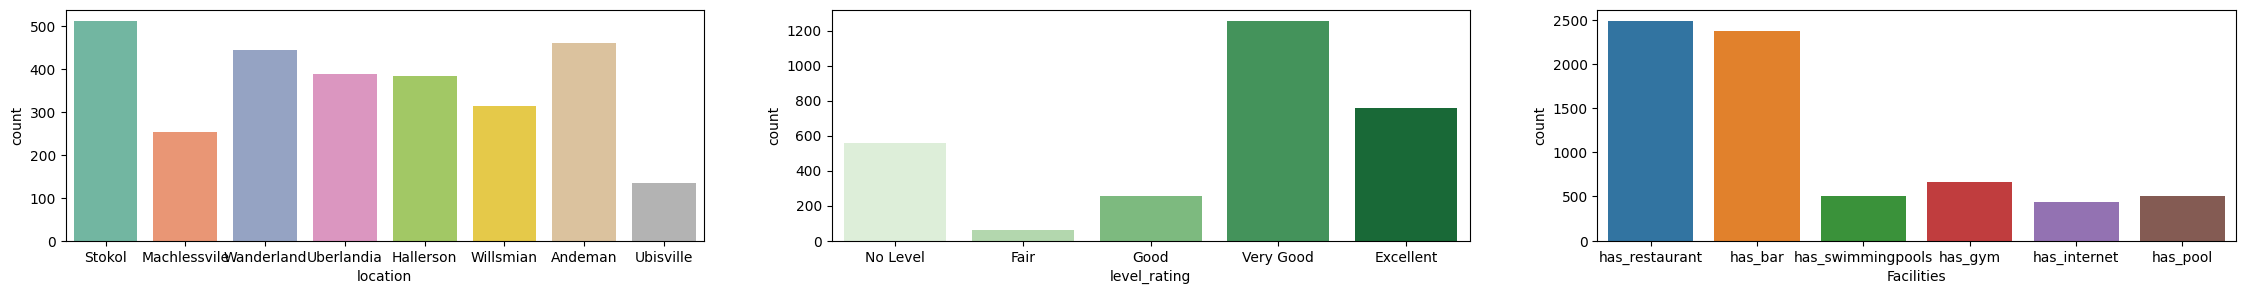

In [ ]:
# Distribution for non-binary columns
facilities_count = pd.DataFrame(train_full[facilities_cols].sum(),columns=['count'])
facilities_count.T

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(28, 3))
sns.countplot(data=train, x='location', ax=ax[0], palette="Set2")
sns.countplot(data=train, x='level_rating', ax=ax[1],order=['No Level','Fair','Good','Very Good','Excellent'], palette="Greens")

sns.barplot(data=facilities_count.T)
plt.xlabel("Facilities")
plt.ylabel("count")

Text(0, 0.5, 'count')

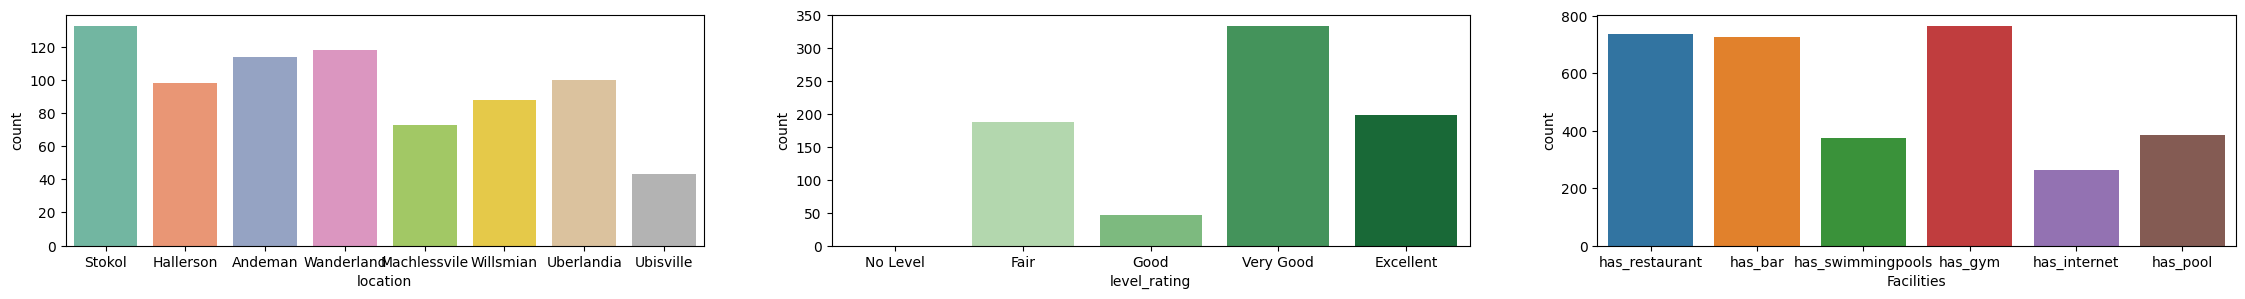

In [ ]:
# Distribution for non-binary columns
facilities_count = pd.DataFrame(test[facilities_cols].sum(),columns=['count'])
facilities_count.T

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(28, 3))
sns.countplot(data=test, x='location', ax=ax[0], palette="Set2")
sns.countplot(data=test, x='level_rating', ax=ax[1],order=['No Level','Fair','Good','Very Good','Excellent'], palette="Greens")

sns.barplot(data=facilities_count.T)
plt.xlabel("Facilities")
plt.ylabel("count")

### **2.2 Bivariate Exploration**

In [ ]:
train_full = train.copy()

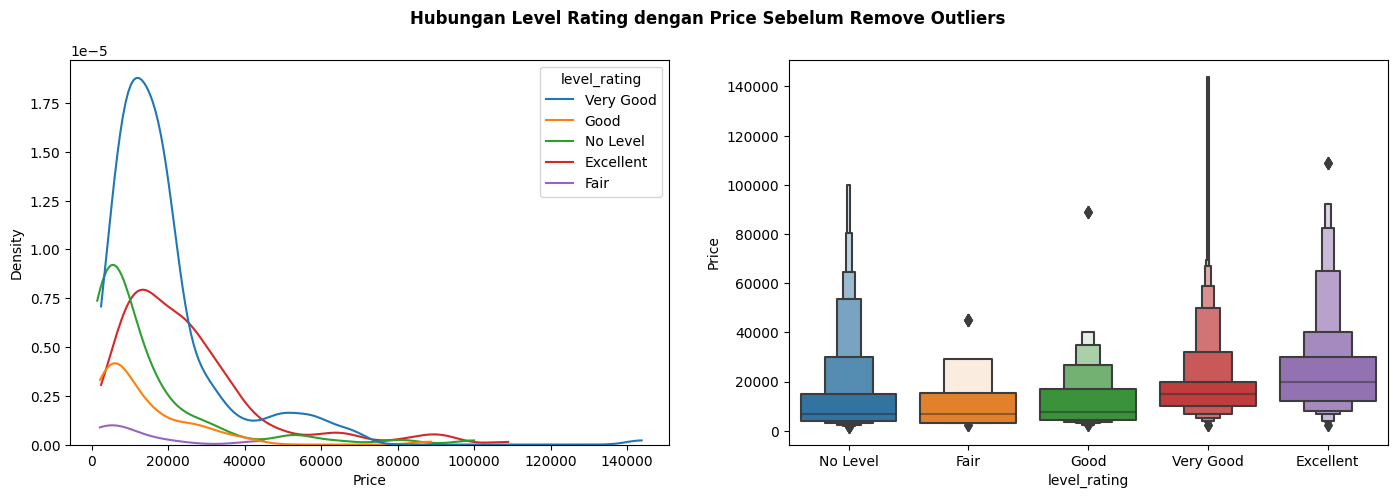

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
sns.kdeplot(data=train_full,x='Price', hue='level_rating', cut=0,ax=ax[0])
sns.boxenplot(data=train_full,x='level_rating',y='Price',ax=ax[1],order=["No Level","Fair","Good","Very Good","Excellent"])
fig.suptitle("Hubungan Level Rating dengan Price Sebelum Remove Outliers",fontweight='bold')
plt.show()

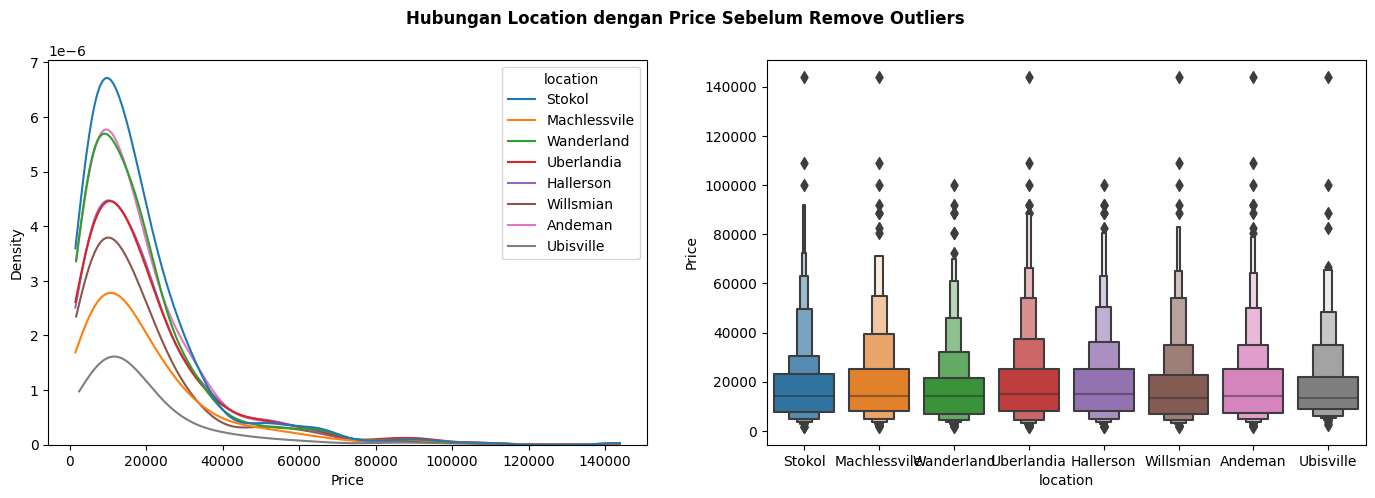

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
sns.kdeplot(data=train_full,x='Price', hue='location', cut=0,ax=ax[0])
sns.boxenplot(data=train_full,x='location',y='Price',ax=ax[1])
fig.suptitle("Hubungan Location dengan Price Sebelum Remove Outliers",fontweight='bold')
plt.show()

Hotel dengan harga diatas 25000 didominasi oleh rating level `Very Good` dan `Excellent`

## EDA untuk Facilities

In [ ]:
greater_3000 = train_full[train_full['Price'] >= 30000] # Itu variabel harusnya _30000
lower_3000 = train_full[train_full['Price'] < 30000]

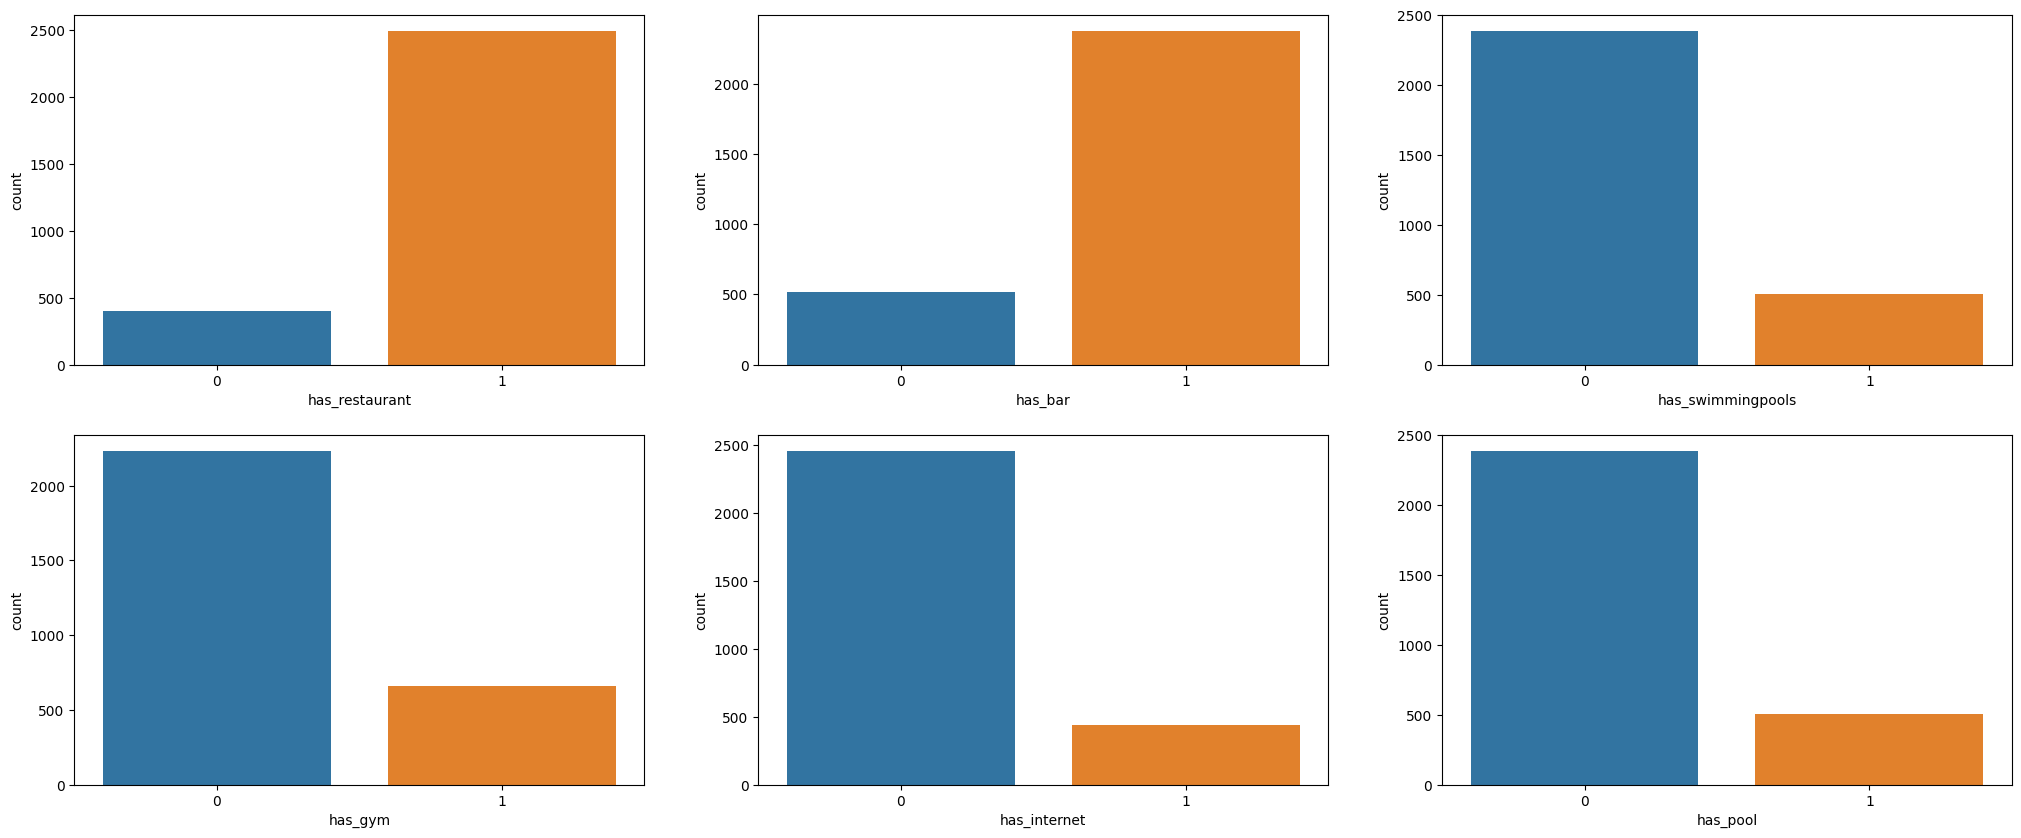

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))

for i, col in enumerate(facilities_cols):
  sns.countplot(data=train_full, x=col, ax=ax[i//3,i%3])

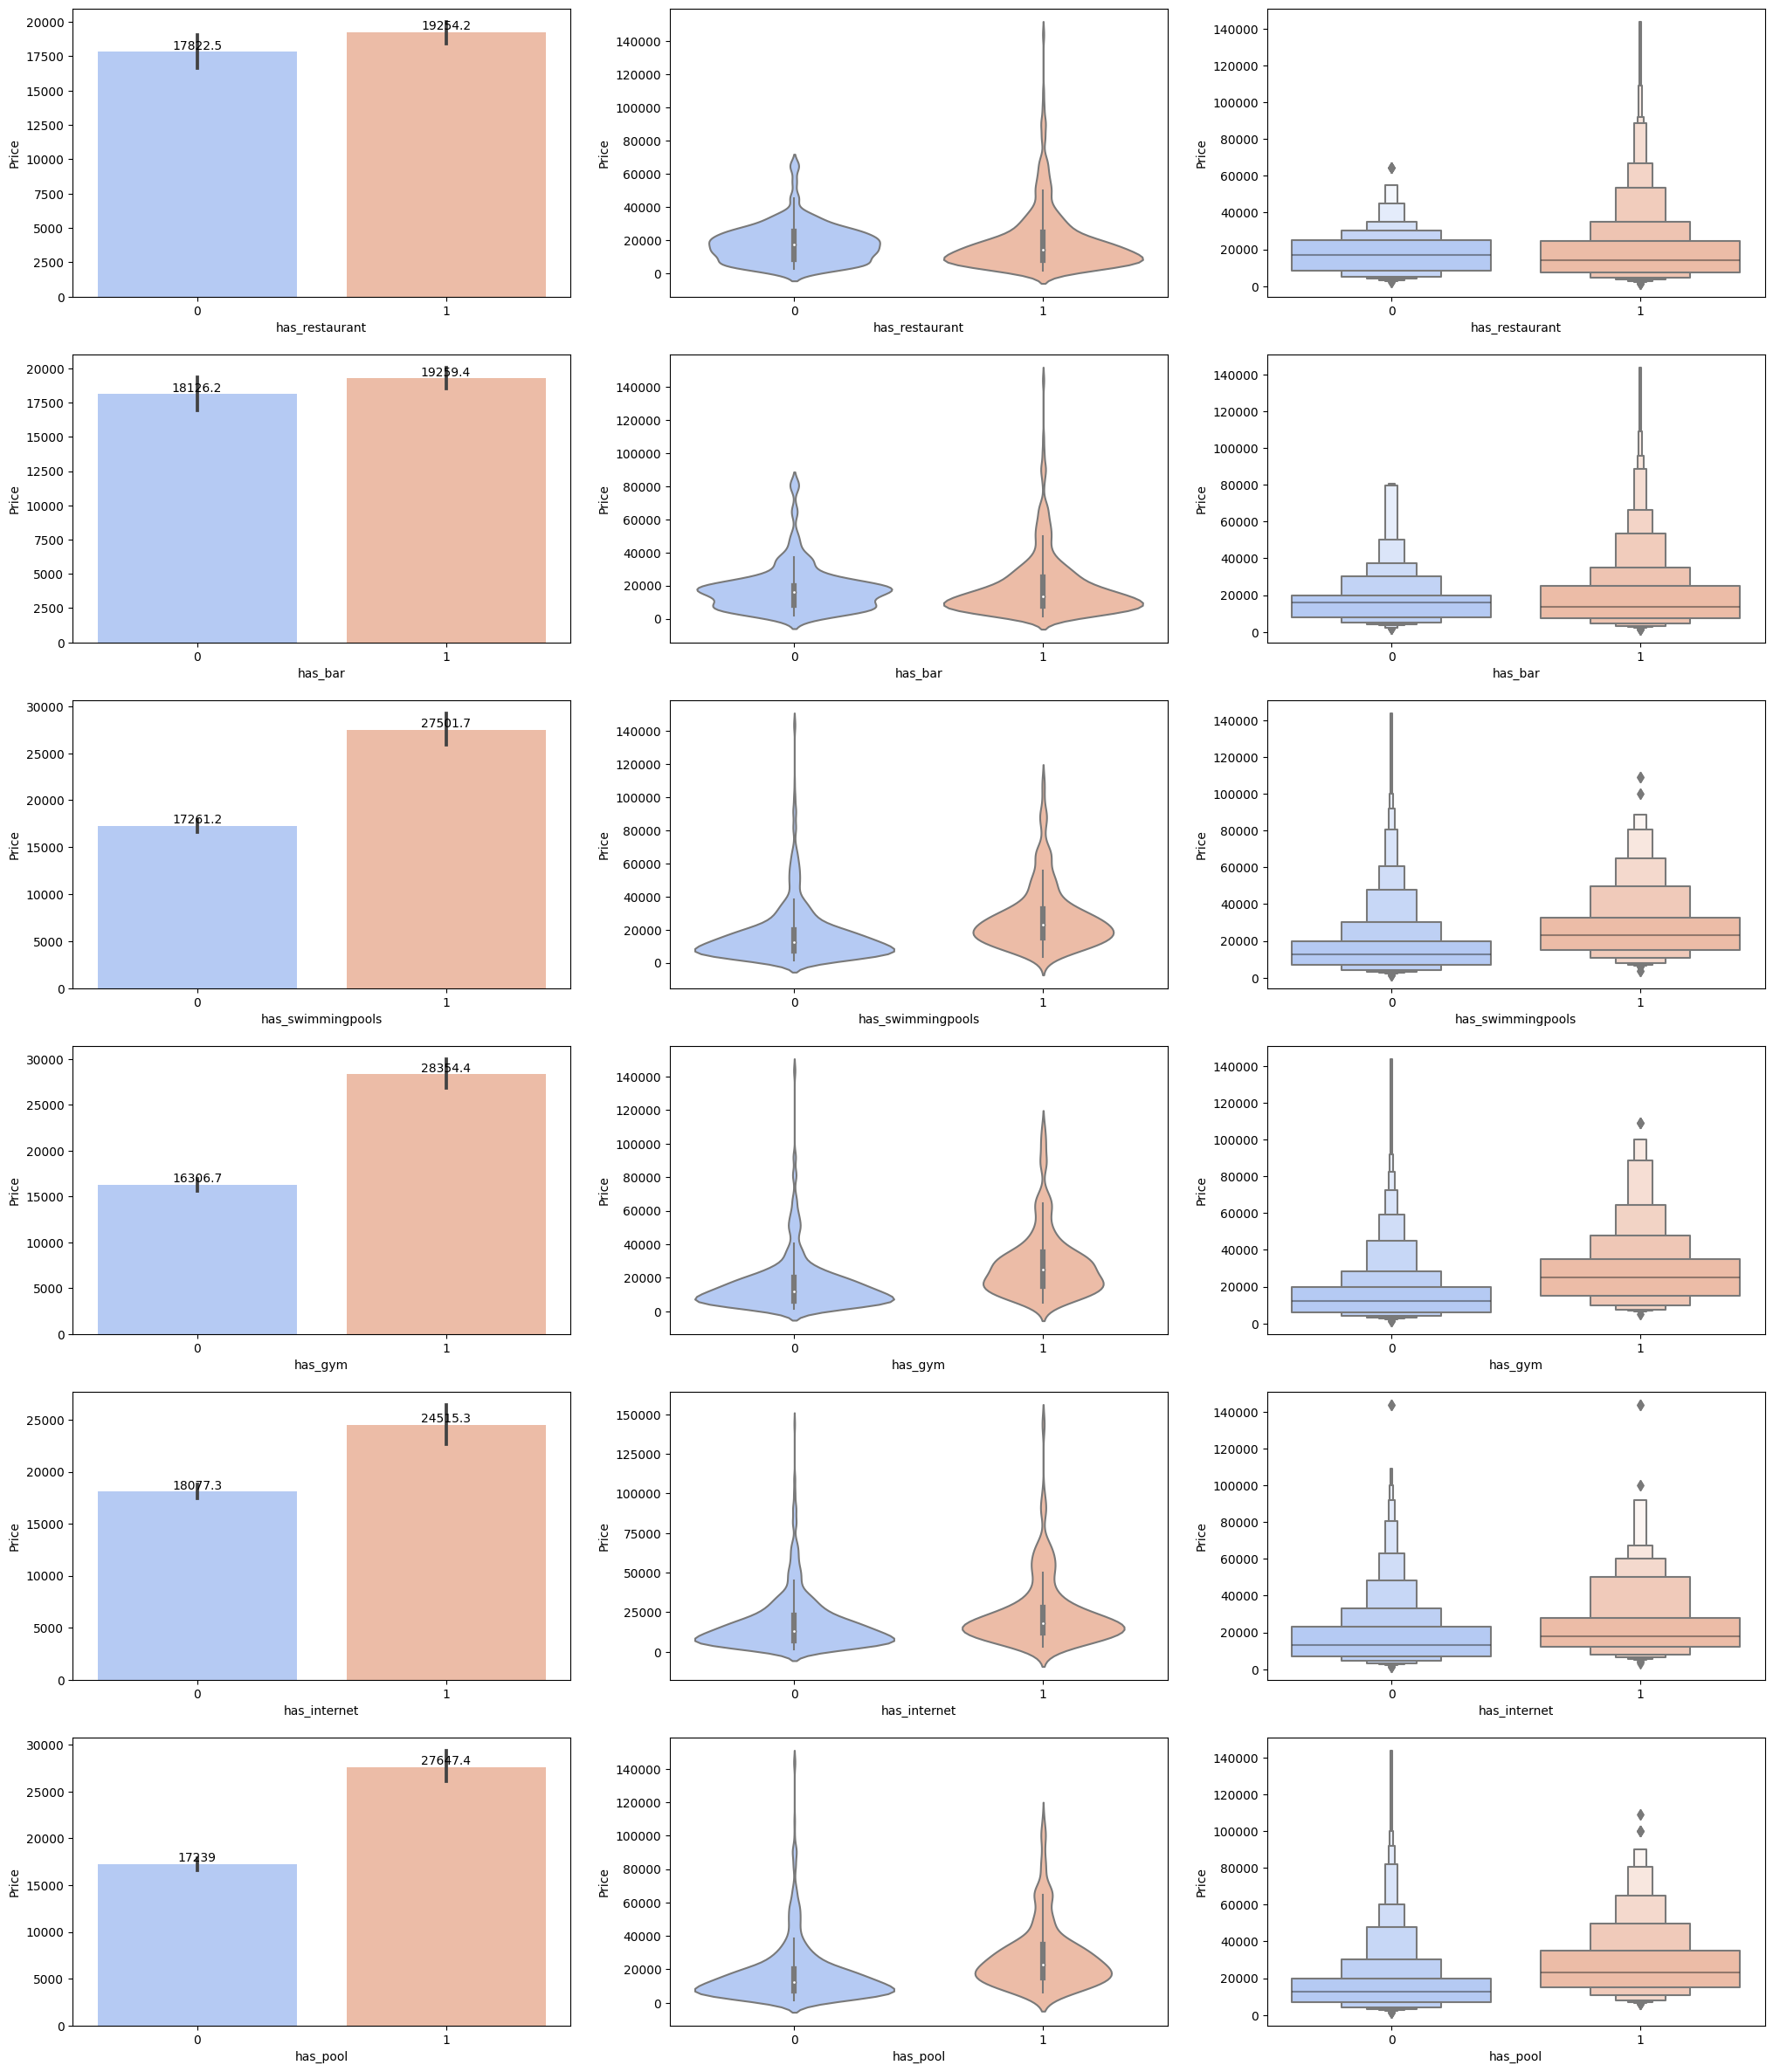

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(25, 30))

for i, col in enumerate(facilities_cols):
    bar = sns.barplot(data=train_full, y='Price', x=col, ax=ax[i, 0], palette="coolwarm")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=train_full, y='Price', x=col, ax=ax[i, 1], palette="coolwarm")
    sns.boxenplot(data=train_full,y="Price",x=col,ax=ax[i, 2], palette="coolwarm")

Adanya fasilitas swimming pool, gym, sama pool cenderung menjadikan price hotel lebih mahal dibanding yang tidak ada fasilitas tersebut
restoran, bar, internet bukan merupakan faktor yang memberikan dampak signifikan ke harga hotel

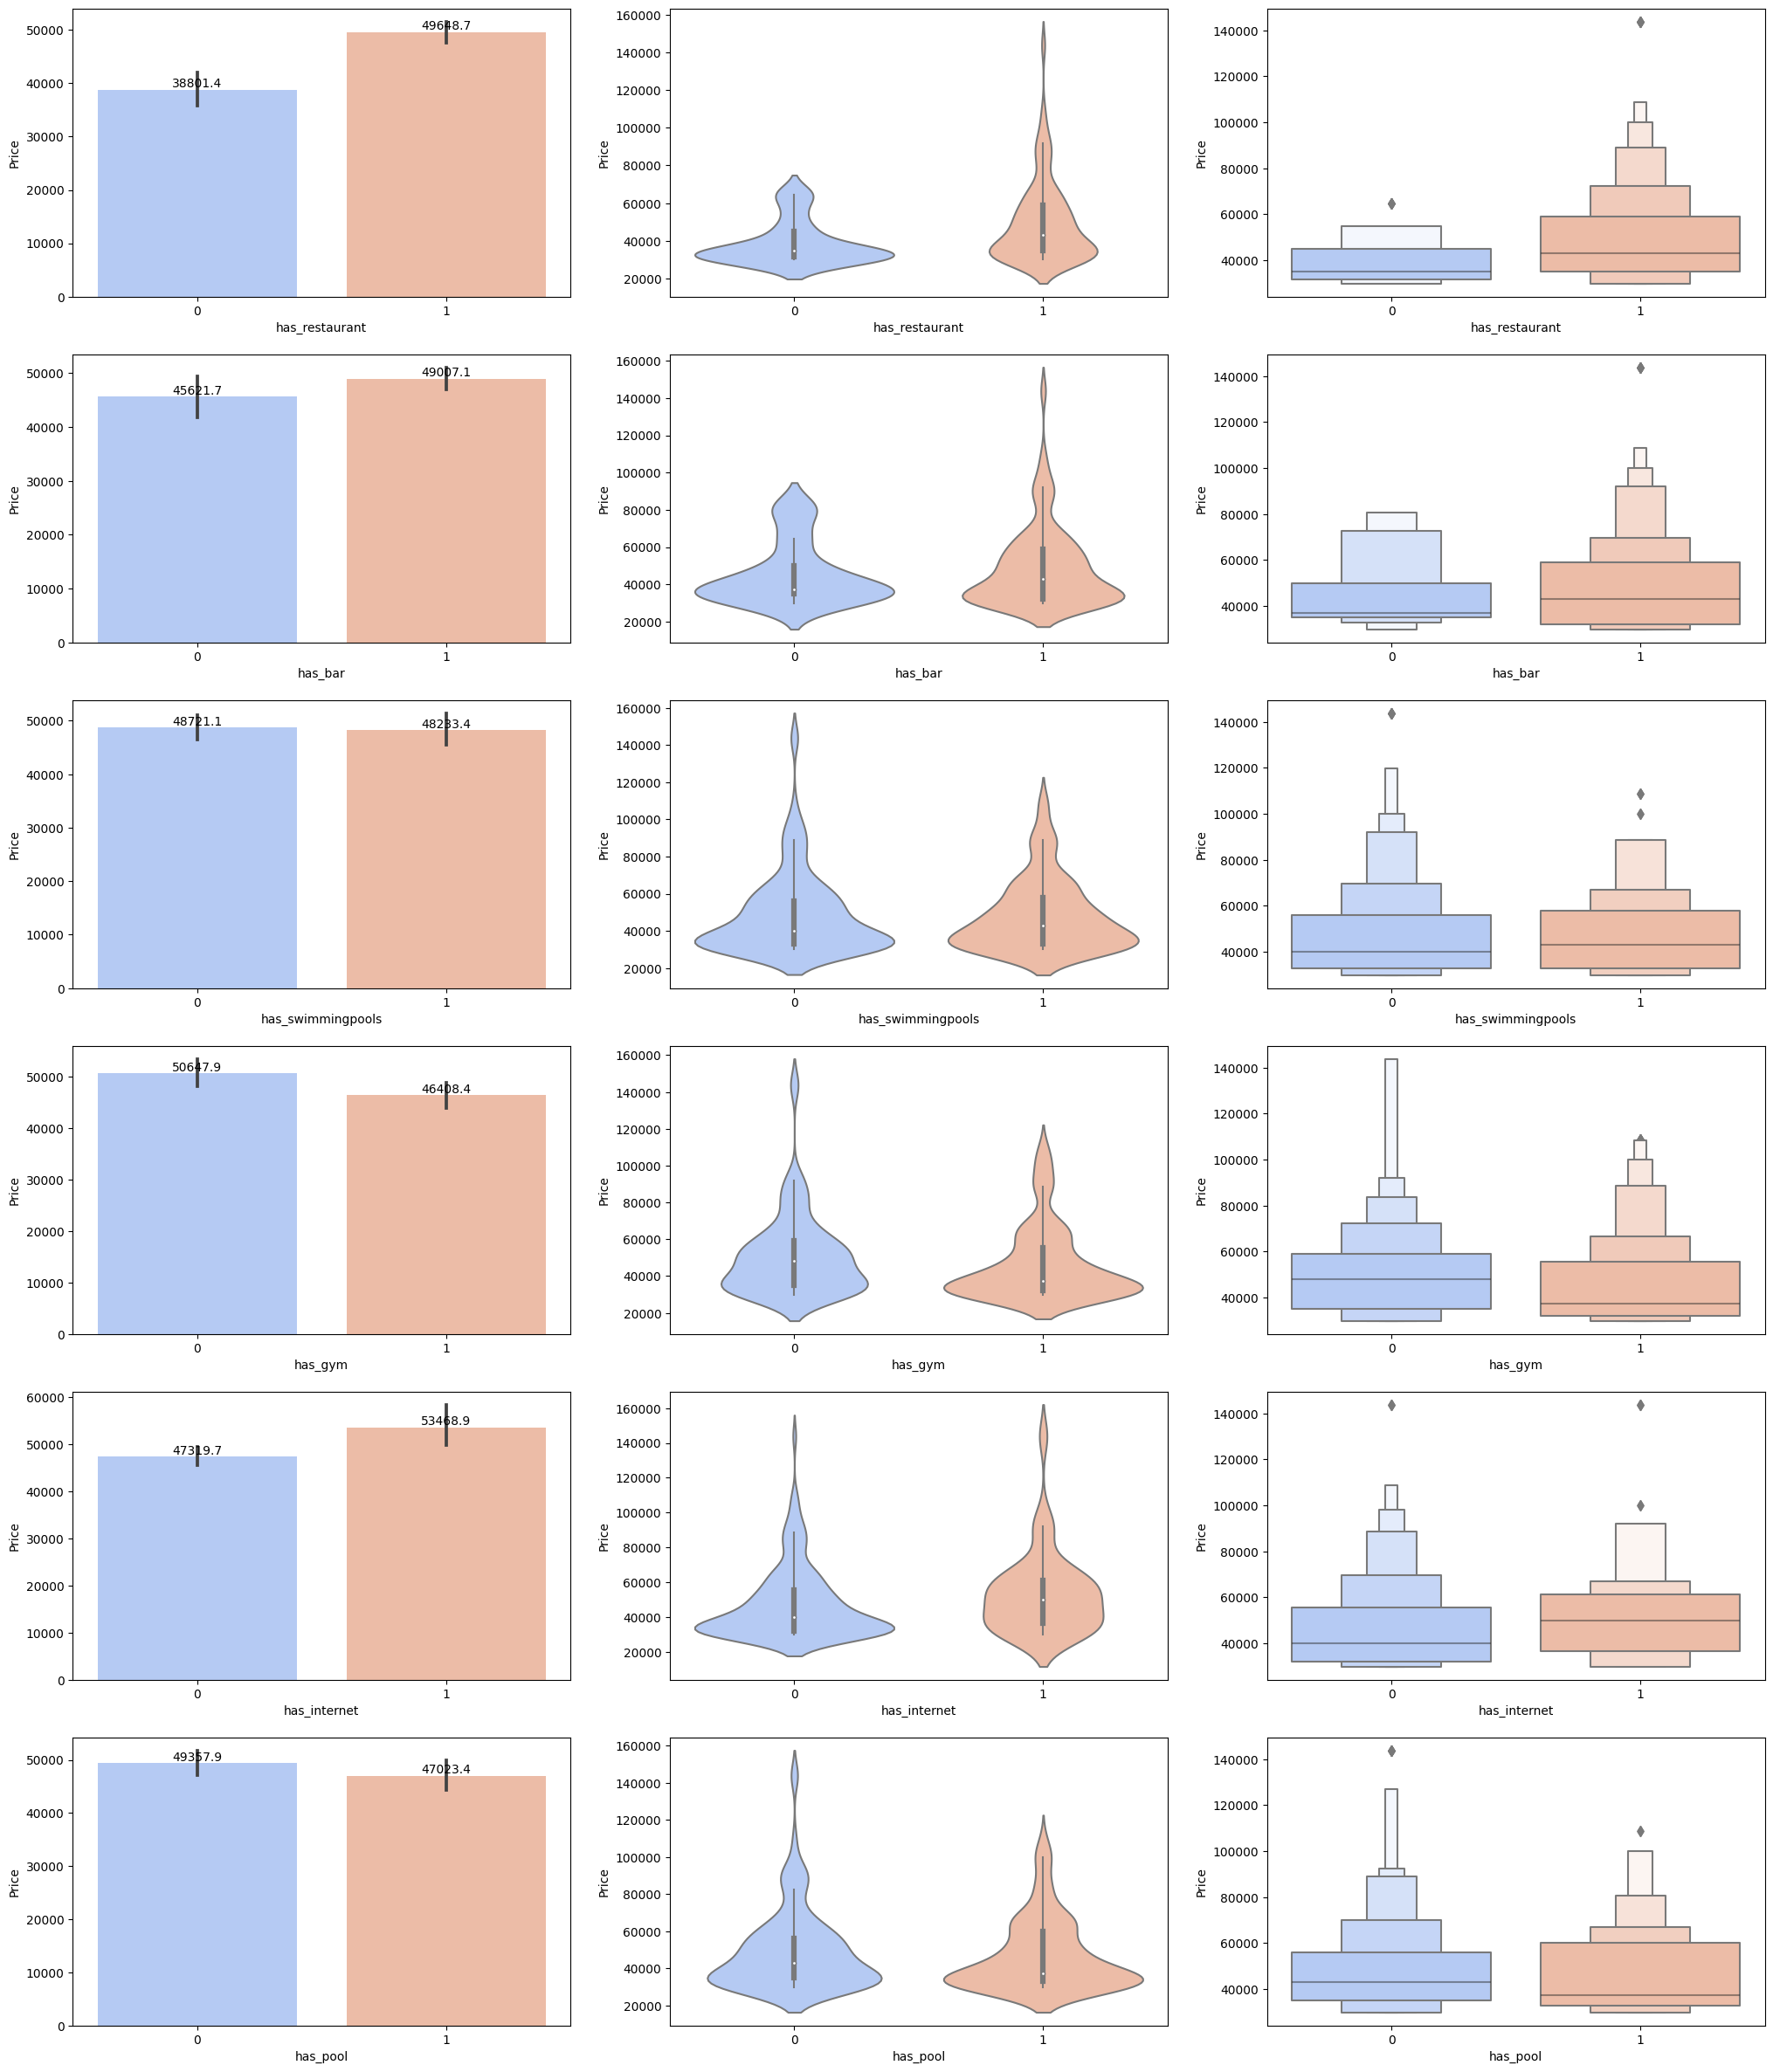

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(25, 30))

for i, col in enumerate(facilities_cols):
    bar = sns.barplot(data=greater_3000, y='Price', x=col, ax=ax[i, 0], palette="coolwarm")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=greater_3000, y='Price', x=col, ax=ax[i, 1], palette="coolwarm")
    sns.boxenplot(data=greater_3000,y="Price",x=col,ax=ax[i, 2], palette="coolwarm")

buat hotel yang harganya kalangan atas (30000 keatas) ternyata harganya lebih terpengaruh sama restoran sama bar

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(25, 30))

for i, col in enumerate(facilities_cols):
    bar = sns.barplot(data=lower_3000, y='Price', x=col, ax=ax[i, 0], palette="coolwarm")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=lower_3000, y='Price', x=col, ax=ax[i, 1], palette="coolwarm")
    sns.boxenplot(data=lower_3000,y="Price",x=col,ax=ax[i, 2], palette="coolwarm")

hotel yang harganya normal (30000 kebawah) ternyata harganya lebih dipengaruhi sama fasilitas sport atau rekreasi gitu kayak swimming pools, pool, sama gym

<Axes: xlabel='level_rating', ylabel='Price'>

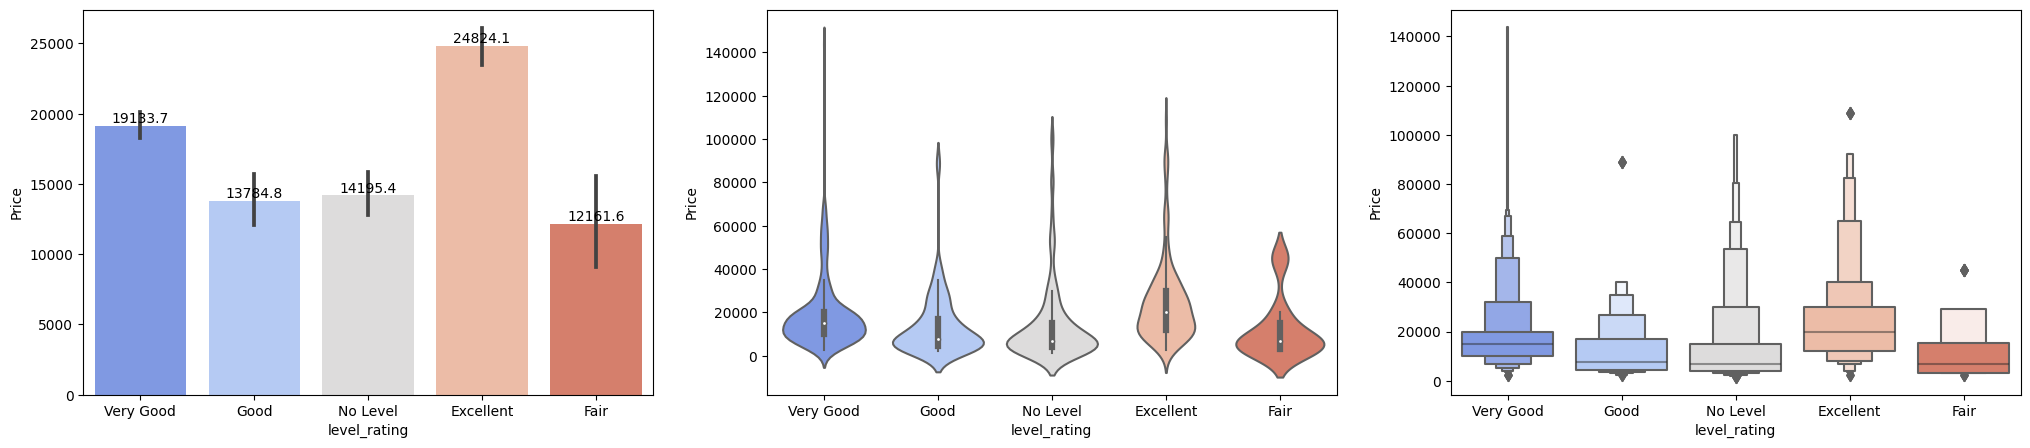

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

bar = sns.barplot(data=train_full, y='Price', x='level_rating', ax=ax[0], palette="coolwarm")
bar.bar_label(bar.containers[0])
sns.violinplot(data=train_full, y='Price', x='level_rating', ax=ax[1], palette="coolwarm")
sns.boxenplot(data=train_full,y="Price",x='level_rating',ax=ax[2], palette="coolwarm")

Dapat dilihat bahwa secara rata-rata semakin tinggi levelnya, maka harga akan cenderung tinggi juga

In [ ]:
print("Untuk Insight di Infografis")
for facility in facilities_cols:
  train_facilities = train_full[train_full[facility]==1]
  print(f"{((train_facilities['Price'] > train_full['Price'].mean()).sum()/ train_facilities.shape[0] * 100):,.2f}% hotel yang memiliki {facility} berada diatas rata-rata")

Untuk Insight di Infografis
34.26% hotel yang memiliki has_restaurant berada diatas rata-rata
34.91% hotel yang memiliki has_bar berada diatas rata-rata
60.55% hotel yang memiliki has_swimmingpools berada diatas rata-rata
60.91% hotel yang memiliki has_gym berada diatas rata-rata
47.27% hotel yang memiliki has_internet berada diatas rata-rata
59.21% hotel yang memiliki has_pool berada diatas rata-rata


## EDA untuk Location

<Axes: xlabel='location', ylabel='Price'>

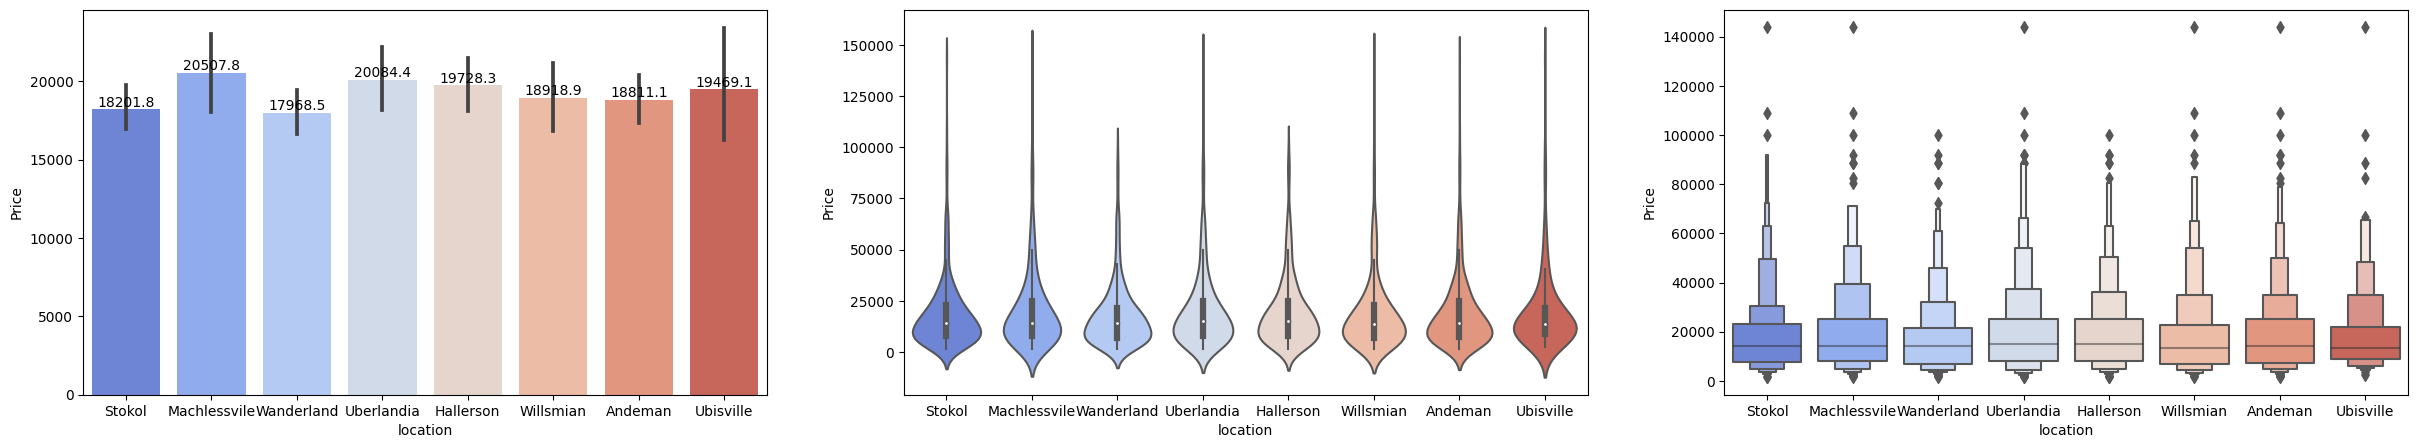

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 5))

bar = sns.barplot(data=train_full, y='Price', x='location', ax=ax[0], palette="coolwarm")
bar.bar_label(bar.containers[0])
sns.violinplot(data=train_full, y='Price', x='location', ax=ax[1], palette="coolwarm")
sns.boxenplot(data=train_full,y="Price",x='location',ax=ax[2], palette="coolwarm")

Distribusi datanya seimbang, tidak ada yang dapat disimpulkan

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.lmplot(data=train_full, x='num_reviews', y='Price', aspect=2, height=3)
# sns.lmplot(data=train_full, x='num_rating', y='Price', aspect=2, height=3)

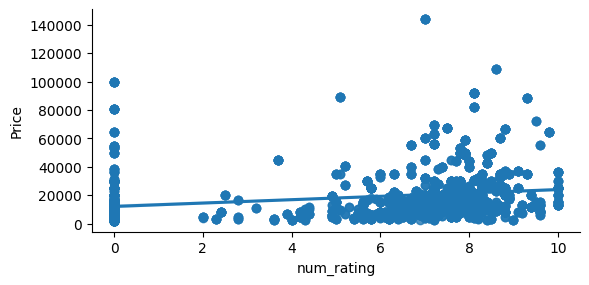

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.lmplot(data=train_full, x='num_rating', y='Price', aspect=2, height=3)

<Axes: xlabel='level_rating', ylabel='count'>

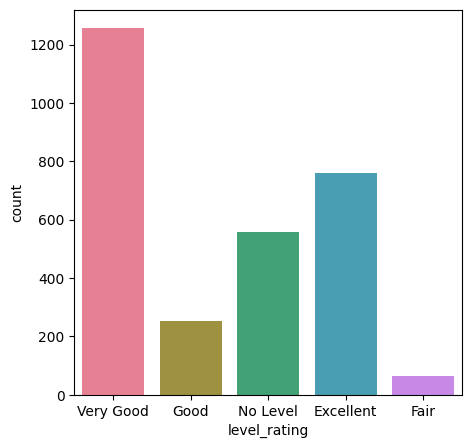

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(data=train_full,x='level_rating', palette="husl")

<ipython-input-531-a8e773cc28a7>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True)


<Axes: >

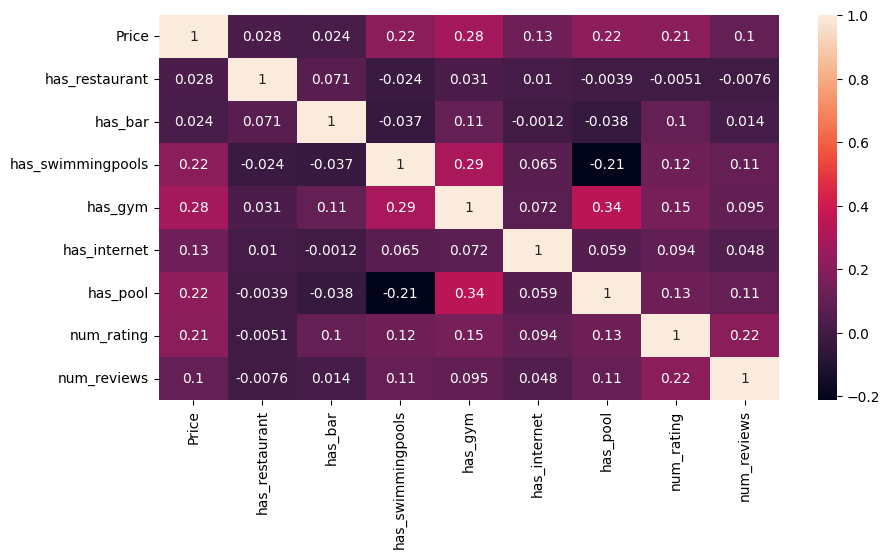

In [ ]:
# Gaada yg multicollinear (?)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.heatmap(train.corr(), annot=True)

In [ ]:
train['location'].unique()

array(['Stokol', 'Machlessvile', 'Wanderland', 'Uberlandia', 'Hallerson',
       'Willsmian', 'Andeman', 'Ubisville'], dtype=object)

# **3. Feature Engineering**

### **Feature selecting**

In [ ]:
for df in [train, test]:
    df["rating_review_combined"] = np.where((df["num_rating"] == 0.0) & (df["num_reviews"] == 0), 0.0, df["num_rating"] * df["num_reviews"])
    df["rating_ratio"] = np.where((df["num_rating"] == 0.0) & (df["num_reviews"] == 0), 0.0, df["num_rating"] / df["num_reviews"])
    df["facility_quality"] = df["rating_ratio"] * df[facilities_cols].sum(axis=1) # JELEK
    df["facilities_count"] = df[facilities_cols].sum(axis=1)

In [ ]:
# Get the number of rows in the train dataframe
train_rows = train.shape[0]

# Concatenate the train and test dataframes vertically
merged_df = pd.concat([train, test])

# Encode object columns using Ordinal Encoding -> manual karena klo factorize urutannya gk sesuai
level_rating_labels = {"Excellent": 4, "Very Good": 3, "Good": 2, "Fair": 1, "No Level": 0}
merged_df["level_rating"] = merged_df["level_rating"].map(level_rating_labels)

# Encode object columns using One-Hot Encoding
merged_df = pd.get_dummies(merged_df, columns=["location"])

# Separate the merged dataframe back into train and test dataframes
train = merged_df.iloc[:train_rows]
test = merged_df.iloc[train_rows:].drop(columns=["Price"])

train.head()

facilities                        rating    Price  \
0  restaurantbarswimmingpools  7.8 Very GoodFrom 10 reviews  13500.0   
1        intrnetrestaurantgym        5.6 GoodFrom 4 reviews  13000.0   
2        restaurantgympoolbar  7.2 Very GoodFrom 38 reviews  19000.0   
3               barrestaurant   7.3 Very GoodFrom 6 reviews   6000.0   
4          internetrestaurant  7.2 Very GoodFrom 30 reviews  20000.0   

   has_restaurant  has_bar  has_swimmingpools  has_gym  has_internet  \
0               1        1                  1        0             0   
1               1        0                  0        1             1   
2               1        1                  0        1             0   
3               1        1                  0        0             0   
4               1        0                  0        0             0   

   has_pool  num_rating  level_rating  num_reviews  rating_review_combined  \
0         0         7.8             3           10                    78.0   
1         0         5.6             2            4                    22.4   
2         1         7.2             3           38                   273.6   
3         0         7.3             3            6                    43.8   
4         0         7.2             3           30                   216.0   

   rating_ratio  facility_quality  facilities_count  location_Andeman  \
0      0.780000          2.340000                 3                 0   
1      1.400000          4.200000                 3                 0   
2      0.189474          0.757895                 4                 0   
3      1.216667          2.433333                 2                 0   
4      0.240000          0.240000                 1                 0   

   location_Hallerson  location_Machlessvile  location_Stokol  \
0                   0                      0                1   
1                   0                      1                0   
2                   0                      0                0   
3                   0                      0                0   
4                   0                      0                1   

   location_Uberlandia  location_Ubisville  location_Wanderland  \
0                    0                   0                    0   
1                    0                   0                    0   
2                    0                   0                    1   
3                    1                   0                    0   
4                    0                   0                    0   

   location_Willsmian  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

#### **Dealing with Outlier**

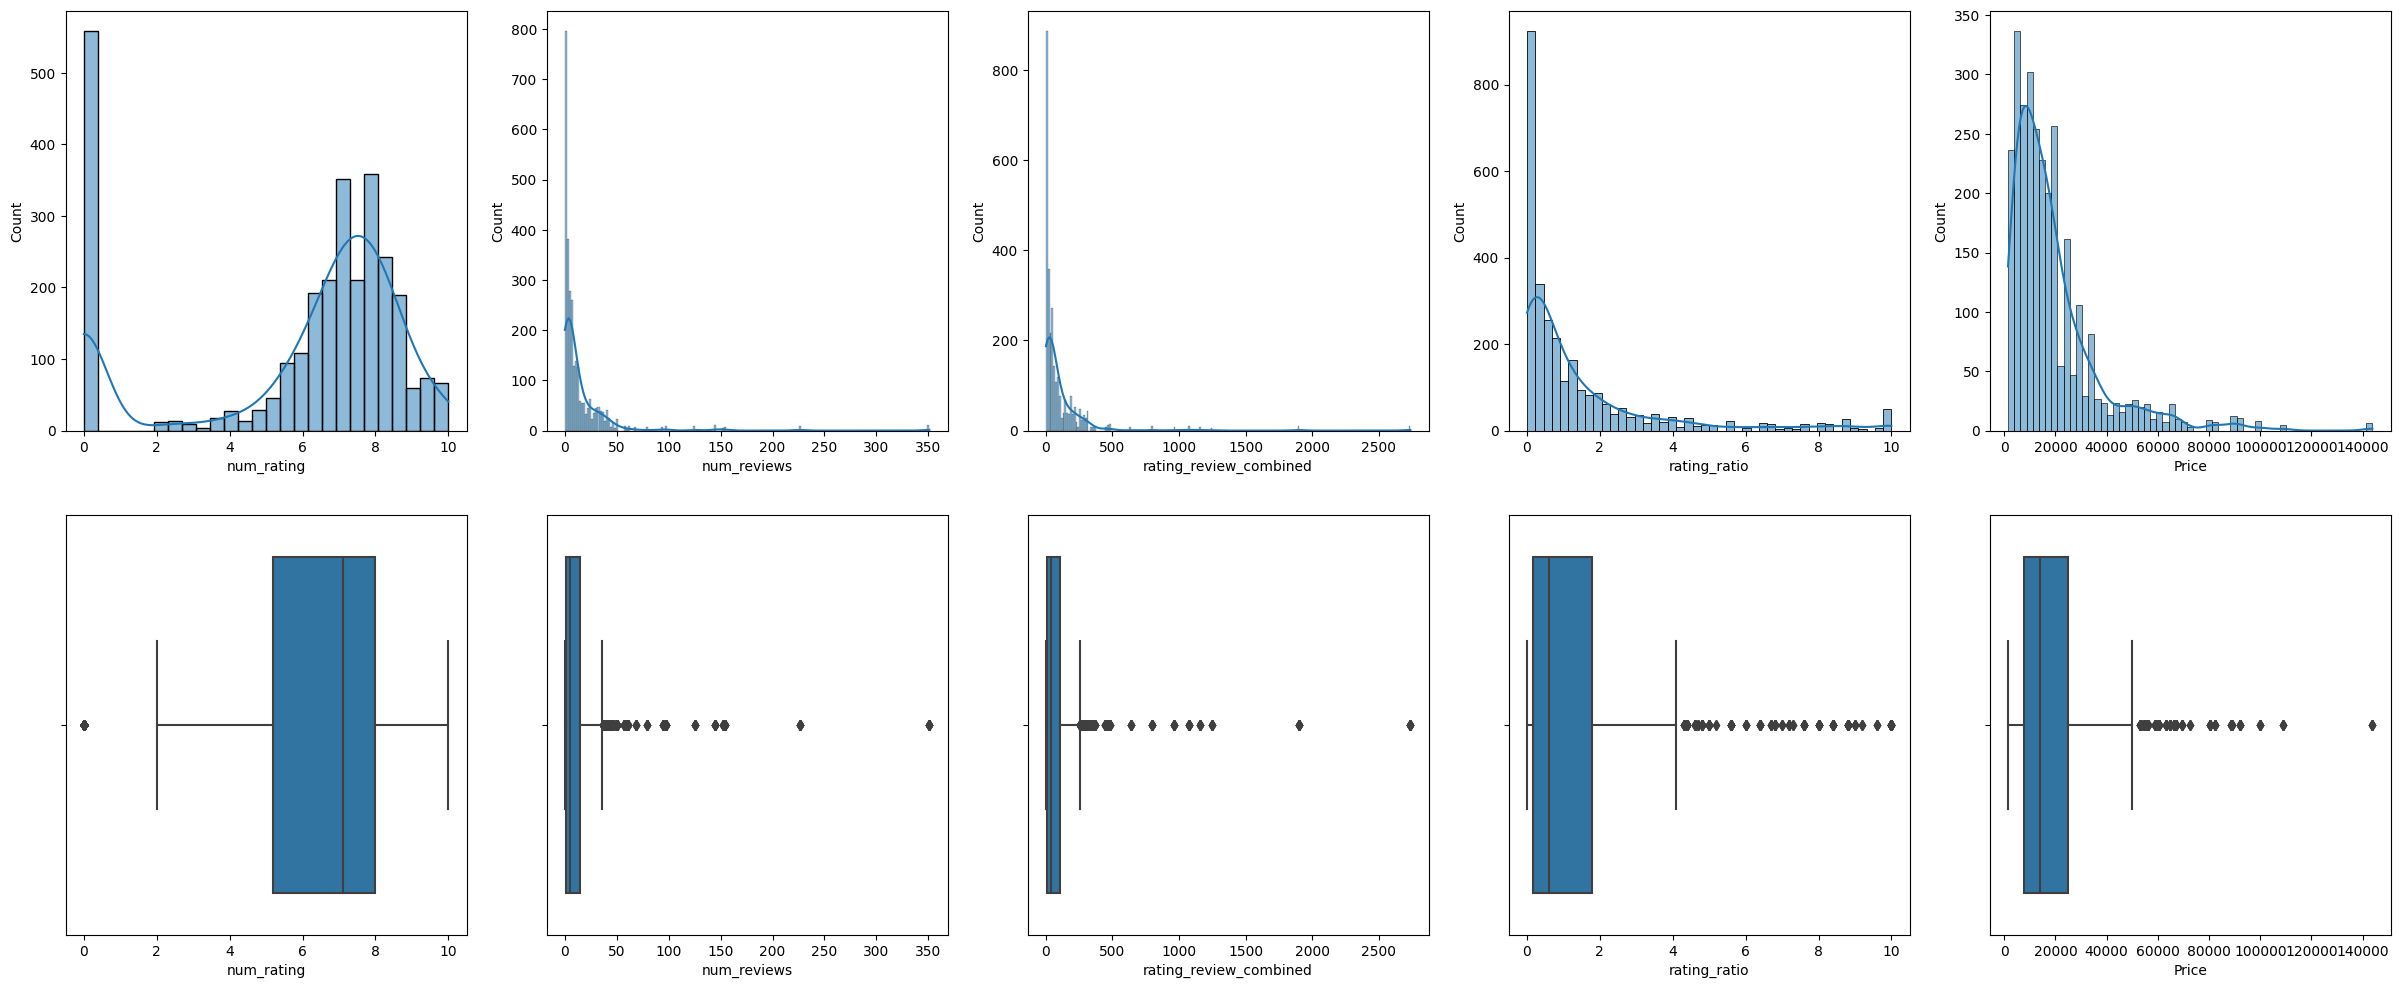

In [ ]:
# Distribution for non-binary columns
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30, 12))

for i, col in enumerate(["num_rating", "num_reviews", "rating_review_combined",  "rating_ratio", "Price"]):
    sns.histplot(data=train, x=col, ax=ax[0, i%5], kde=True)
    sns.boxplot(data=train,x = col, ax=ax[1, i%5])

In [ ]:
train.shape

(2891, 24)

In [ ]:
# INI NAIKIN SCORE
def remove_outlier(data, cols):
    idx_todrop = []
    for k in cols:
        q1 = np.quantile(data[k], 0.25)
        q3 = np.quantile(data[k], 0.75)
        iqr = q3 - q1
        idx_list = data[(data[k] >= (q3 + 1.5*iqr)) | (data[k] <= (q1 - 1.5*iqr))].index.to_list()
        idx_todrop.extend(idx_list)
    return list(set(idx_todrop))

idx_to_drop = remove_outlier(train, ["num_rating", "num_reviews", "rating_ratio", "rating_review_combined", "Price"])
train = train.drop(index=list(set(idx_to_drop))).reset_index(drop=True) # Tidak menghapus outlier test!

In [ ]:
train.shape

(1612, 24)

In [ ]:
check_level_rating = train.groupby(['level_rating', 'num_rating']).agg([len])
check_level_rating

facilities rating Price has_restaurant has_bar  \
                               len    len   len            len     len   
level_rating num_rating                                                  
1            2.0                 6      6     6              6       6   
             2.3                 6      6     6              6       6   
             2.4                 9      9     9              9       9   
             2.5                 5      5     5              5       5   
             2.8                 9      9     9              9       9   
             3.2                 3      3     3              3       3   
             3.6                10     10    10             10      10   
             3.7                 8      8     8              8       8   
             3.9                 6      6     6              6       6   
2            4.0                 7      7     7              7       7   
             4.2                14     14    14             14      14   
             4.3                 5      5     5              5       5   
             4.9                29     29    29             29      29   
             5.0                19     19    19             19      19   
             5.1                 6      6     6              6       6   
             5.2                12     12    12             12      12   
             5.3                 2      2     2              2       2   
             5.4                15     15    15             15      15   
             5.5                11     11    11             11      11   
             5.6                20     20    20             20      20   
             5.7                 8      8     8              8       8   
             5.8                34     34    34             34      34   
             5.9                 7      7     7              7       7   
3            6.0                22     22    22             22      22   
             6.1                19     19    19             19      19   
             6.2                42     42    42             42      42   
             6.3                39     39    39             39      39   
             6.4                41     41    41             41      41   
             6.5                33     33    33             33      33   
             6.6                34     34    34             34      34   
             6.7                35     35    35             35      35   
             6.8                30     30    30             30      30   
             6.9                73     73    73             73      73   
             7.0                62     62    62             62      62   
             7.1                66     66    66             66      66   
             7.2                69     69    69             69      69   
             7.3                48     48    48             48      48   
             7.4                54     54    54             54      54   
             7.5                18     18    18             18      18   
             7.6                57     57    57             57      57   
             7.7                48     48    48             48      48   
             7.8                67     67    67             67      67   
             7.9                49     49    49             49      49   
4            8.0                95     95    95             95      95   
             8.1                37     37    37             37      37   
             8.2                32     32    32             32      32   
             8.3                72     72    72             72      72   
             8.4                30     30    30             30      30   
             8.5                42     42    42             42      42   
             8.6                18     18    18             18      18   
             8.7                39     39    39             39      39   
             8.8            

In [ ]:
check_level_rating = test.groupby(['level_rating', 'num_rating']).agg([len])
check_level_rating

facilities rating has_restaurant has_bar  \
                               len    len            len     len   
level_rating num_rating                                            
1            0.0               162    162            162     162   
             2.0                 3      3              3       3   
             2.3                 1      1              1       1   
             2.5                 1      1              1       1   
             2.8                 3      3              3       3   
             3.6                 5      5              5       5   
             3.7                 1      1              1       1   
             4.0                 1      1              1       1   
             4.3                 1      1              1       1   
             4.4                 4      4              4       4   
             4.9                 6      6              6       6   
2            5.0                 4      4              4       4   
             5.1                 9      9              9       9   
             5.2                 6      6              6       6   
             5.4                 2      2              2       2   
             5.5                 1      1              1       1   
             5.6                16     16             16      16   
             5.7                 2      2              2       2   
             5.8                 6      6              6       6   
             5.9                 1      1              1       1   
3            6.0                 9      9              9       9   
             6.1                 5      5              5       5   
             6.2                 7      7              7       7   
             6.3                16     16             16      16   
             6.4                15     15             15      15   
             6.5                 8      8              8       8   
             6.6                 7      7              7       7   
             6.7                 9      9              9       9   
             6.8                17     17             17      17   
             6.9                15     15             15      15   
             7.0                25     25             25      25   
             7.1                20     20             20      20   
             7.2                33     33             33      33   
             7.3                19     19             19      19   
             7.4                20     20             20      20   
             7.5                22     22             22      22   
             7.6                20     20             20      20   
             7.7                22     22             22      22   
             7.8                30     30             30      30   
             7.9                15     15             15      15   
4            8.0                34     34             34      34   
             8.1                17     17             17      17   
             8.2                15     15             15      15   
             8.3                18     18             18      18   
             8.4                16     16             16      16   
             8.5                 7      7              7       7   
             8.6                12     12             12      12   
             8.7                 9      9              9       9   
             8.8                18     18             18      18   
             8.9                 4      4              4       4   
             9.0                 2      2              2       2   
             9.1                 5      5              5       5   
             9.2                 6      6              6       6   
             9.3                 4      4              4       4   
             9.4                 2      2              2       2   
             9.5                 2      2              2       2   
            

In [ ]:
# Distribution for non-binary columns
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30, 12))

for i, col in enumerate(["num_rating", "num_reviews", "rating_review_combined",  "rating_ratio", "Price"]):
    sns.histplot(data=train, x=col, ax=ax[0, i%5], kde=True)
    sns.boxplot(data=train,x = col, ax=ax[1, i%5])

In [ ]:
# Distribution for non-binary columns
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, col in enumerate(["Price","num_rating",'num_reviews']):
    sns.histplot(data=train, x=col, ax=ax[i%3], kde=True)
    # sns.boxplot(data=train,x = col, ax=ax[1, i%3])
    # probplot(train[col],plot=ax[2, i%3])

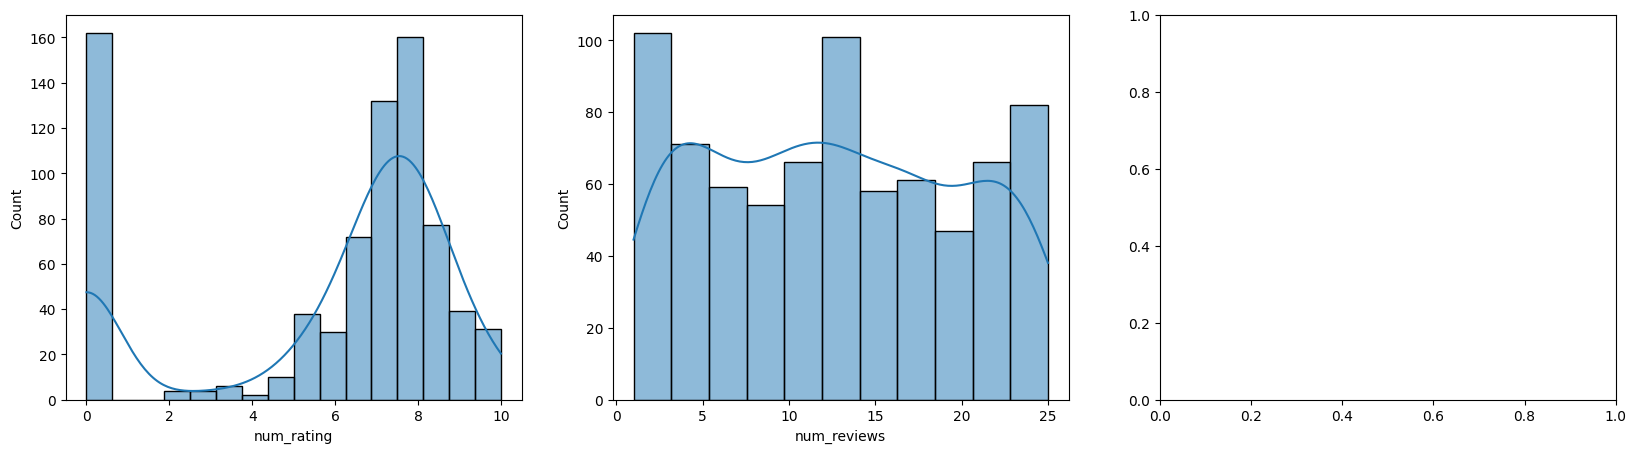

In [ ]:
# Distribution for non-binary columns
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

for i, col in enumerate(["num_rating",'num_reviews']):
    sns.histplot(data=test, x=col, ax=ax[i%3], kde=True)

Text(0, 0.5, 'count')

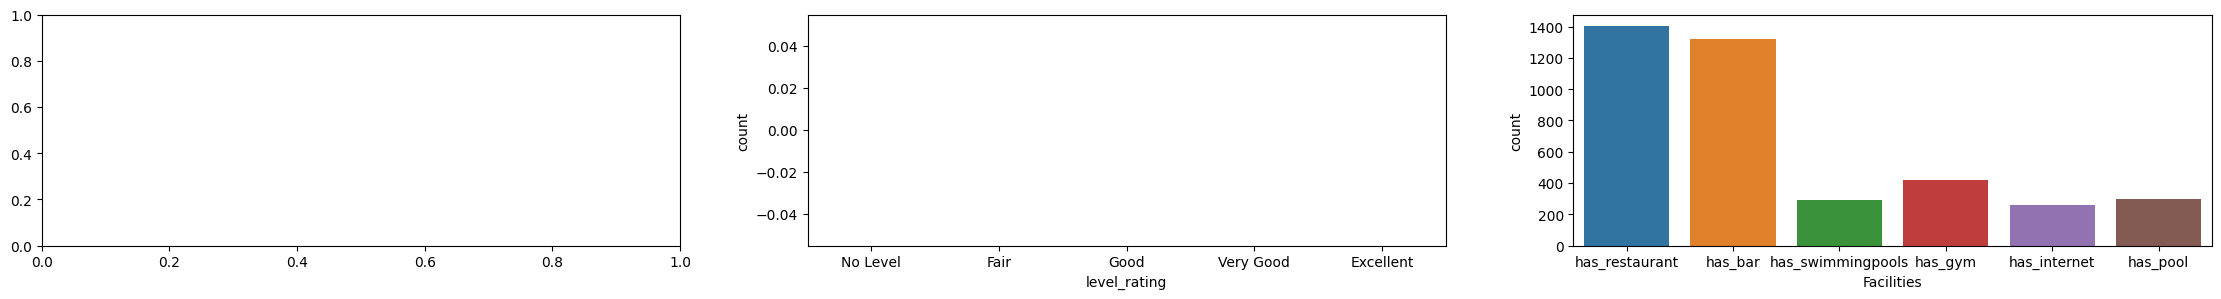

In [ ]:
# Distribution for non-binary columns
facilities_count = pd.DataFrame(train[facilities_cols].sum(),columns=['count'])
facilities_count.T

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(28, 3))
# sns.countplot(data=train, x='location', ax=ax[0], palette="Set2")
sns.countplot(data=train, x='level_rating', ax=ax[1],order=['No Level','Fair','Good','Very Good','Excellent'], palette="Greens")

sns.barplot(data=facilities_count.T)
plt.xlabel("Facilities")
plt.ylabel("count")

In [ ]:
# Distribution for non-binary columns
facilities_count = pd.DataFrame(test[facilities_cols].sum(),columns=['count'])
facilities_count.T

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(28, 3))
# sns.countplot(data=test, x='location', ax=ax[0], palette="Set2")
sns.countplot(data=test, x='level_rating', ax=ax[1],order=['No Level','Fair','Good','Very Good','Excellent'], palette="Greens")

sns.barplot(data=facilities_count.T)
plt.xlabel("Facilities")
plt.ylabel("count")

Text(0, 0.5, 'count')

In [ ]:
greater_3000 = train[train['Price'] >= 30000]
lower_3000 = train[train['Price'] < 30000]

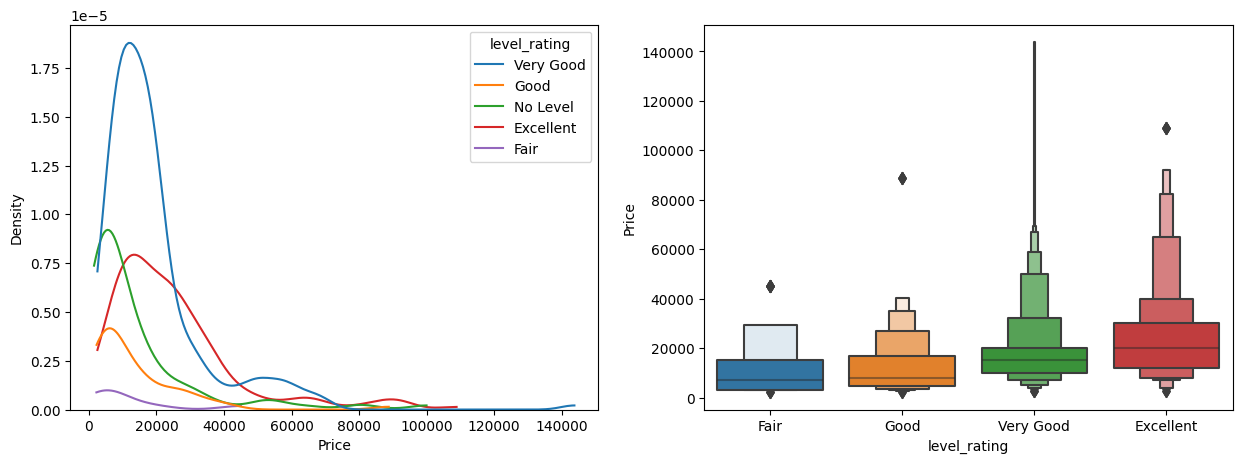

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.kdeplot(data=train_full,x='Price', hue='level_rating', cut=0,ax=ax[0])
sns.boxenplot(data=train_full,x='level_rating',y='Price',ax=ax[1],order=["Fair","Good","Very Good","Excellent"])
plt.show()

Hotel dengan harga lebih dari 25000 di dominasi oleh hotel dengan rating yang `VeryGood` dan `Excellent`



In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
# sns.kdeplot(data=train,x='Price', hue='location', cut=0,ax=ax[0])
# sns.boxenplot(data=train,x='location',y='Price',ax=ax[1])
# fig.suptitle("Hubungan Location dengan Price Setelah Remove Outliers",fontweight='bold')

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.kdeplot(data=train,x='Price', hue='level_rating', cut=0,ax=ax[0])
sns.boxenplot(data=train,x='level_rating',y='Price',ax=ax[1],order=["Fair","Good","Very Good","Excellent"])
fig.suptitle("Hubungan Level Rating dengan Price Setelah Remove Outliers",fontweight='bold')


Text(0.5, 0.98, 'Hubungan Level Rating dengan Price Setelah Remove Outliers')

## EDA untuk Facilities

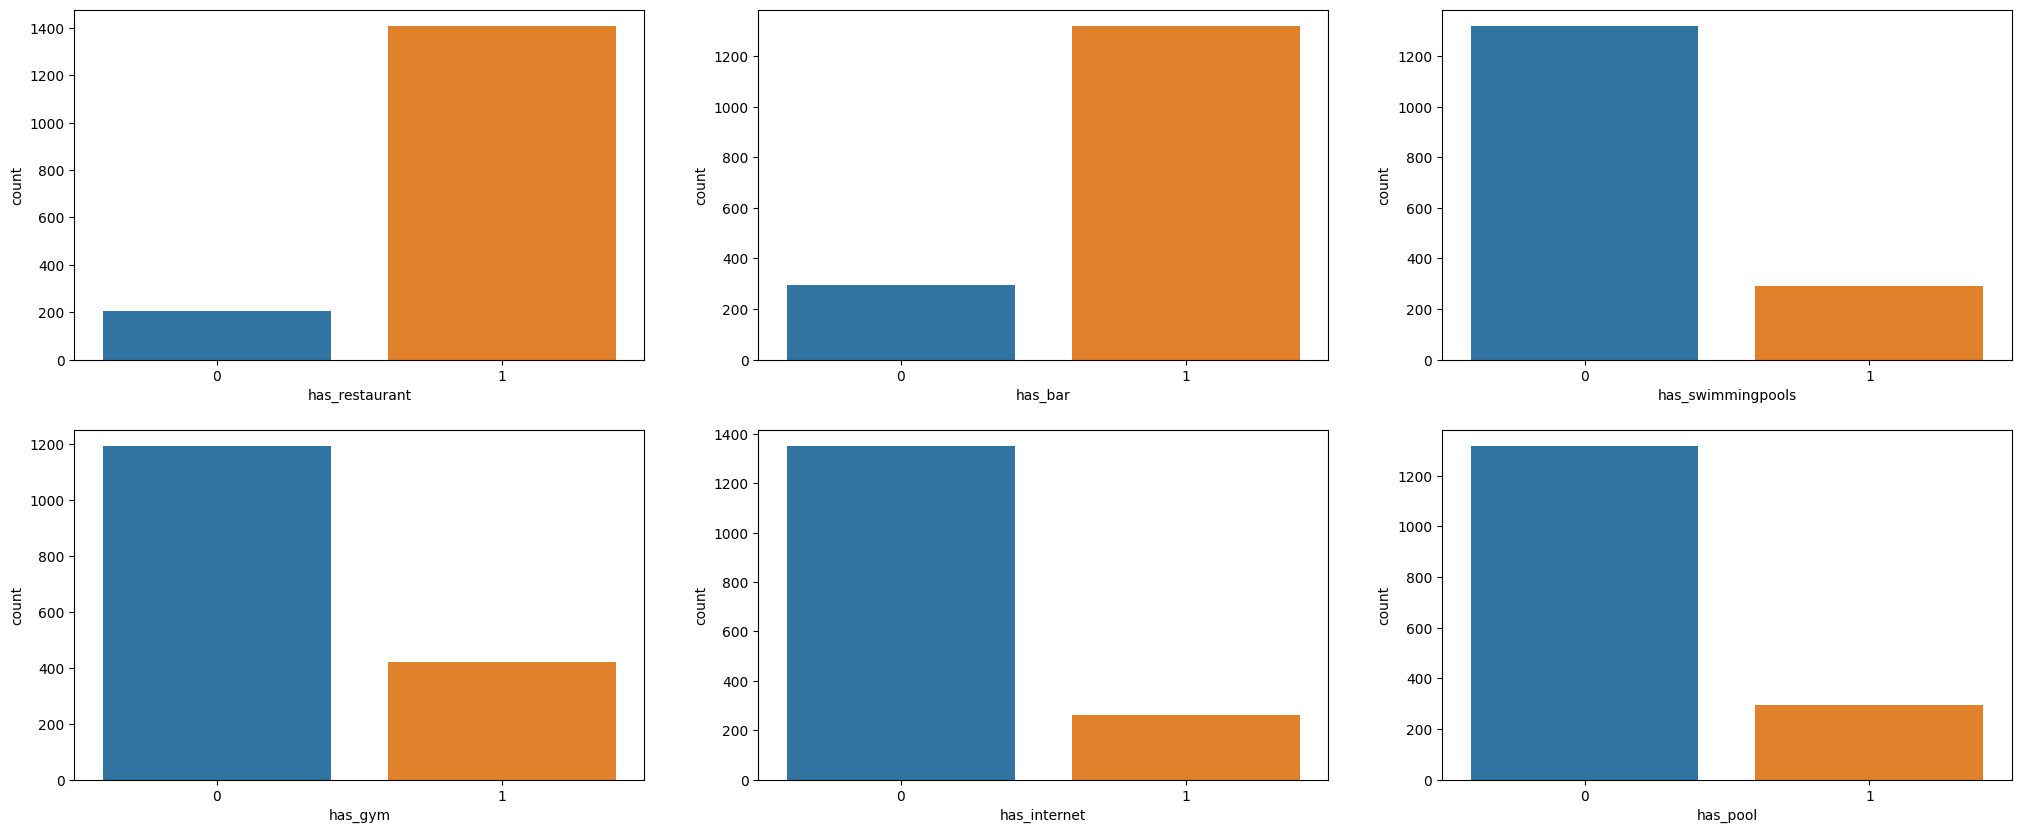

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))

for i, col in enumerate(facilities_cols):
  sns.countplot(data=train, x=col, ax=ax[i//3,i%3])

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(25, 30))

for i, col in enumerate(facilities_cols):
    bar = sns.barplot(data=train, y='Price', x=col, ax=ax[i, 0], palette="coolwarm")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=train, y='Price', x=col, ax=ax[i, 1], palette="coolwarm")
    sns.boxenplot(data=train,y="Price",x=col,ax=ax[i, 2], palette="coolwarm")

Adanya fasilitas swimming pool, gym, sama pool cenderung menjadikan price hotel lebih mahal dibanding yang tidak ada fasilitas tersebut restoran, bar, internet bukan merupakan faktor yang memberikan dampak signifikan ke harga hotel

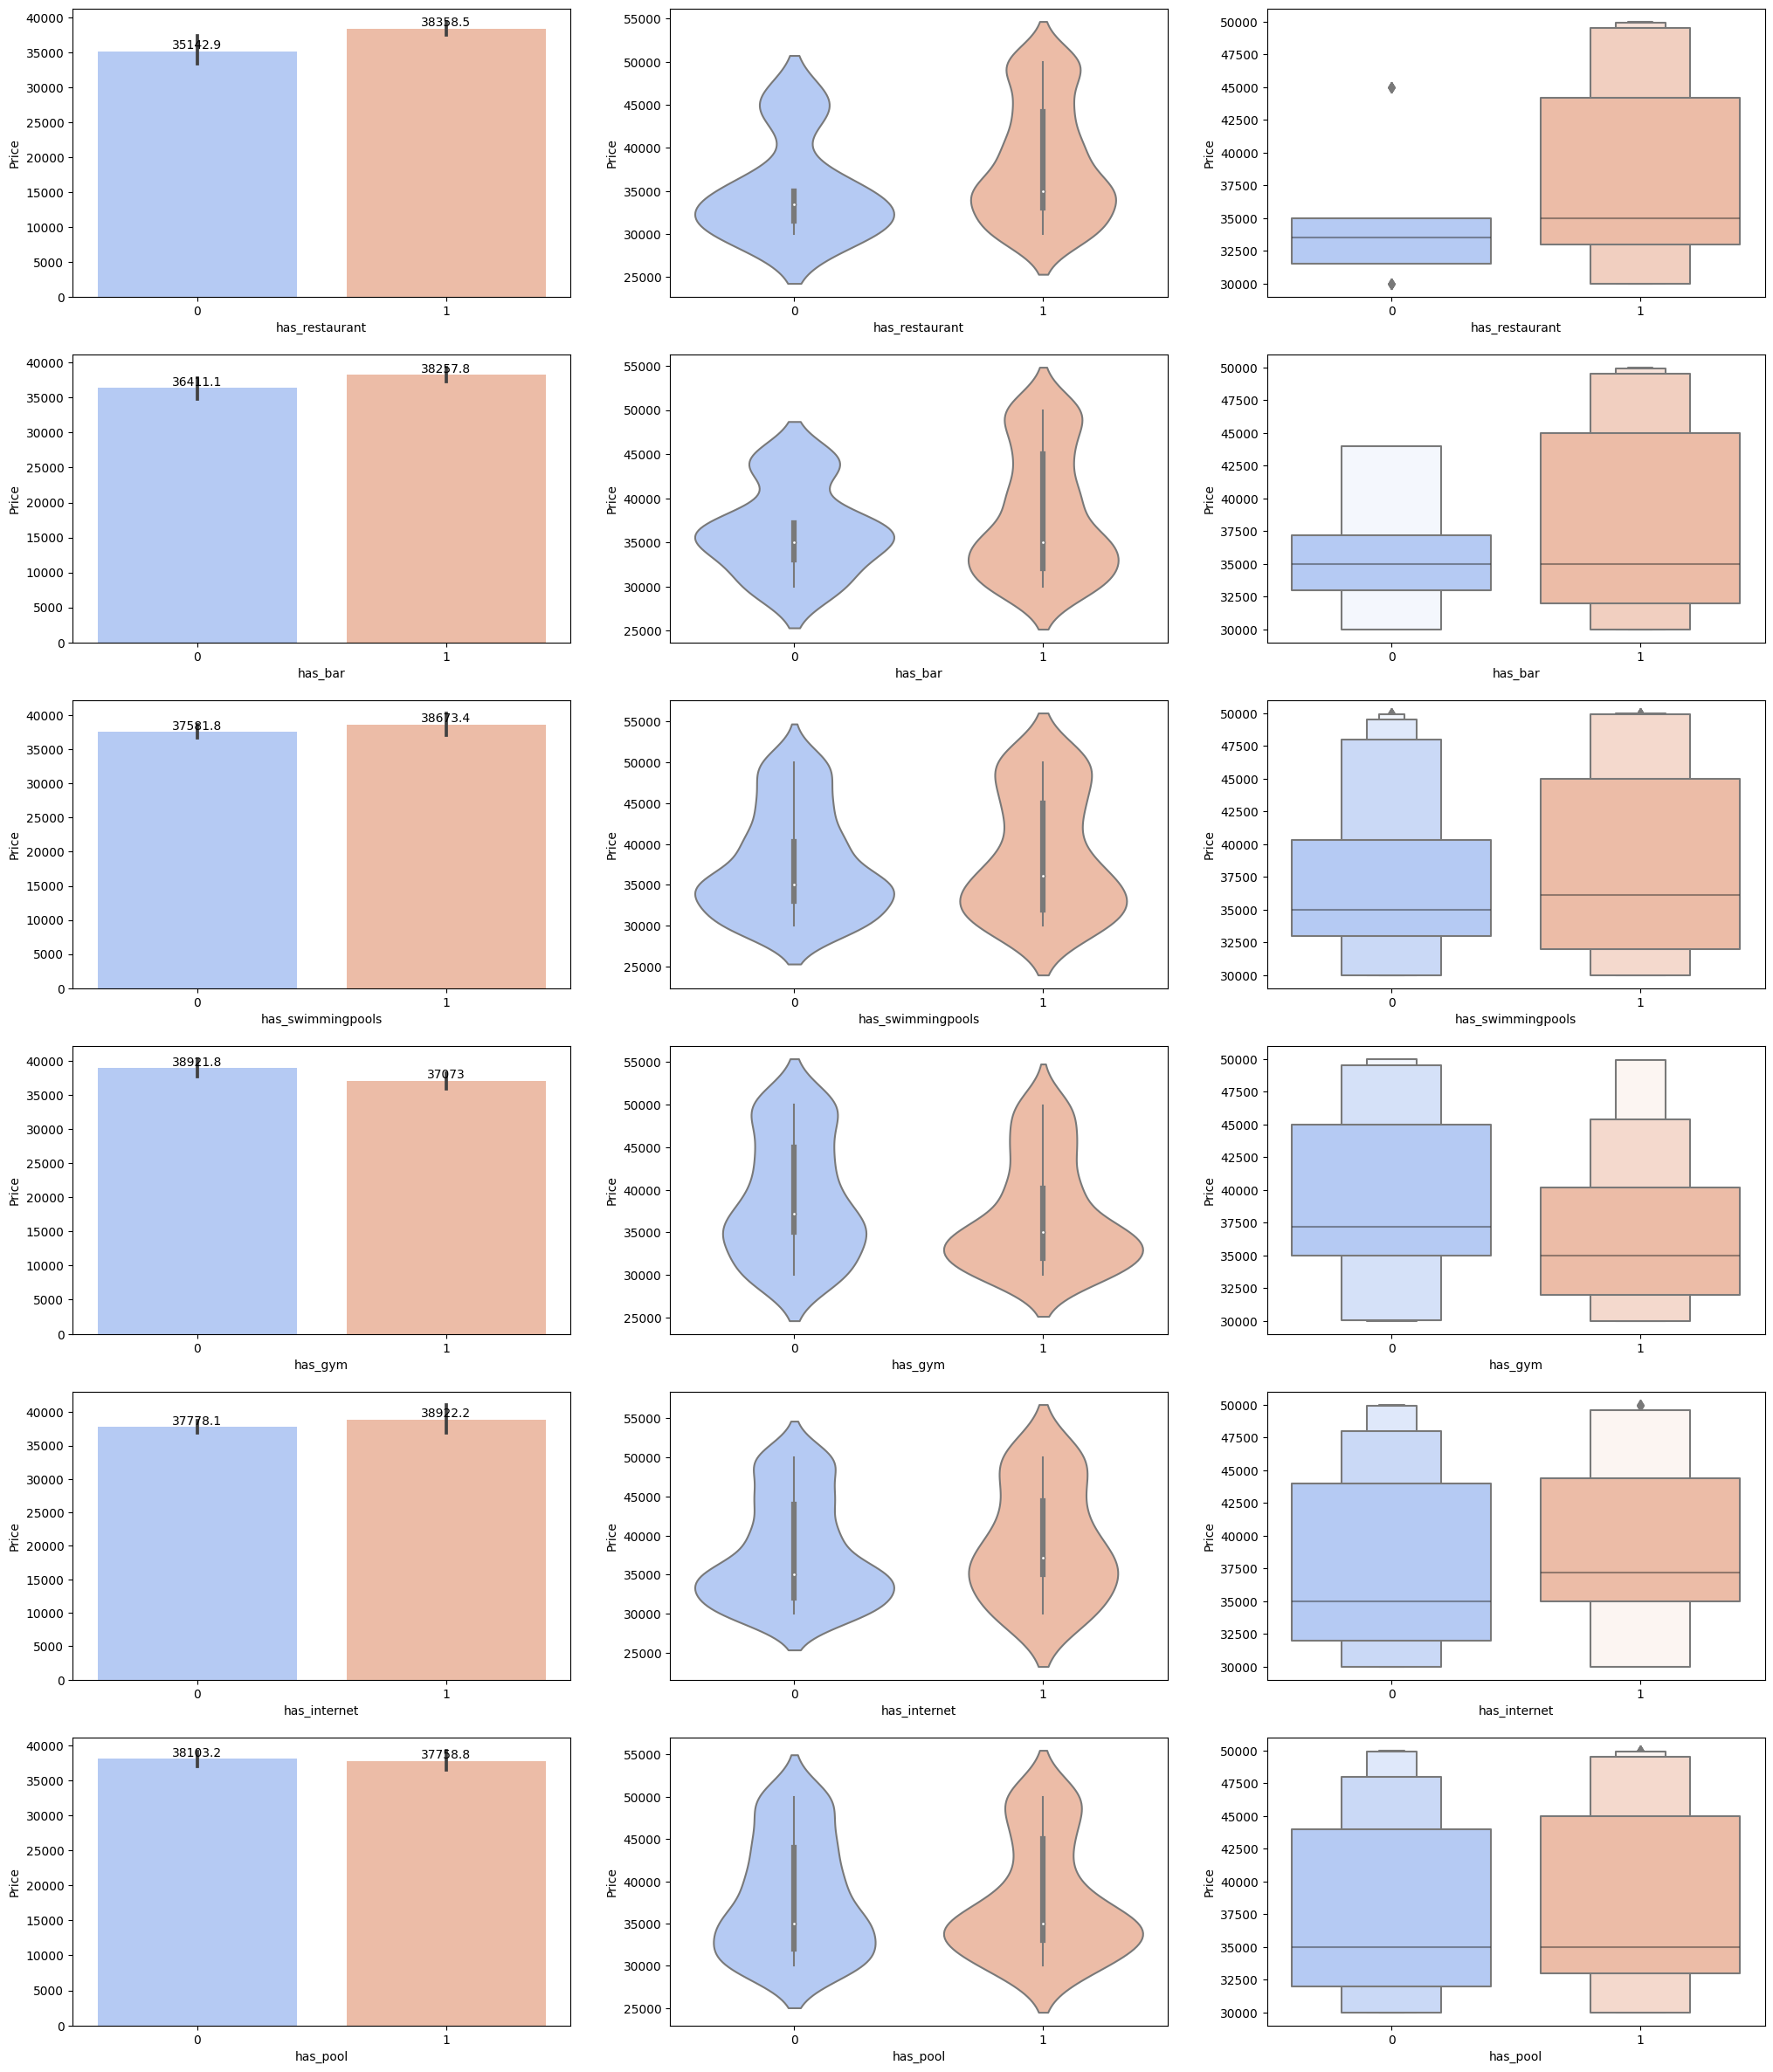

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(25, 30))

for i, col in enumerate(facilities_cols):
    bar = sns.barplot(data=greater_3000, y='Price', x=col, ax=ax[i, 0], palette="coolwarm")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=greater_3000, y='Price', x=col, ax=ax[i, 1], palette="coolwarm")
    sns.boxenplot(data=greater_3000,y="Price",x=col,ax=ax[i, 2], palette="coolwarm")

buat hotel yang harganya kalangan atas (30000 keatas) ternyata harganya lebih terpengaruh sama restoran sama bar

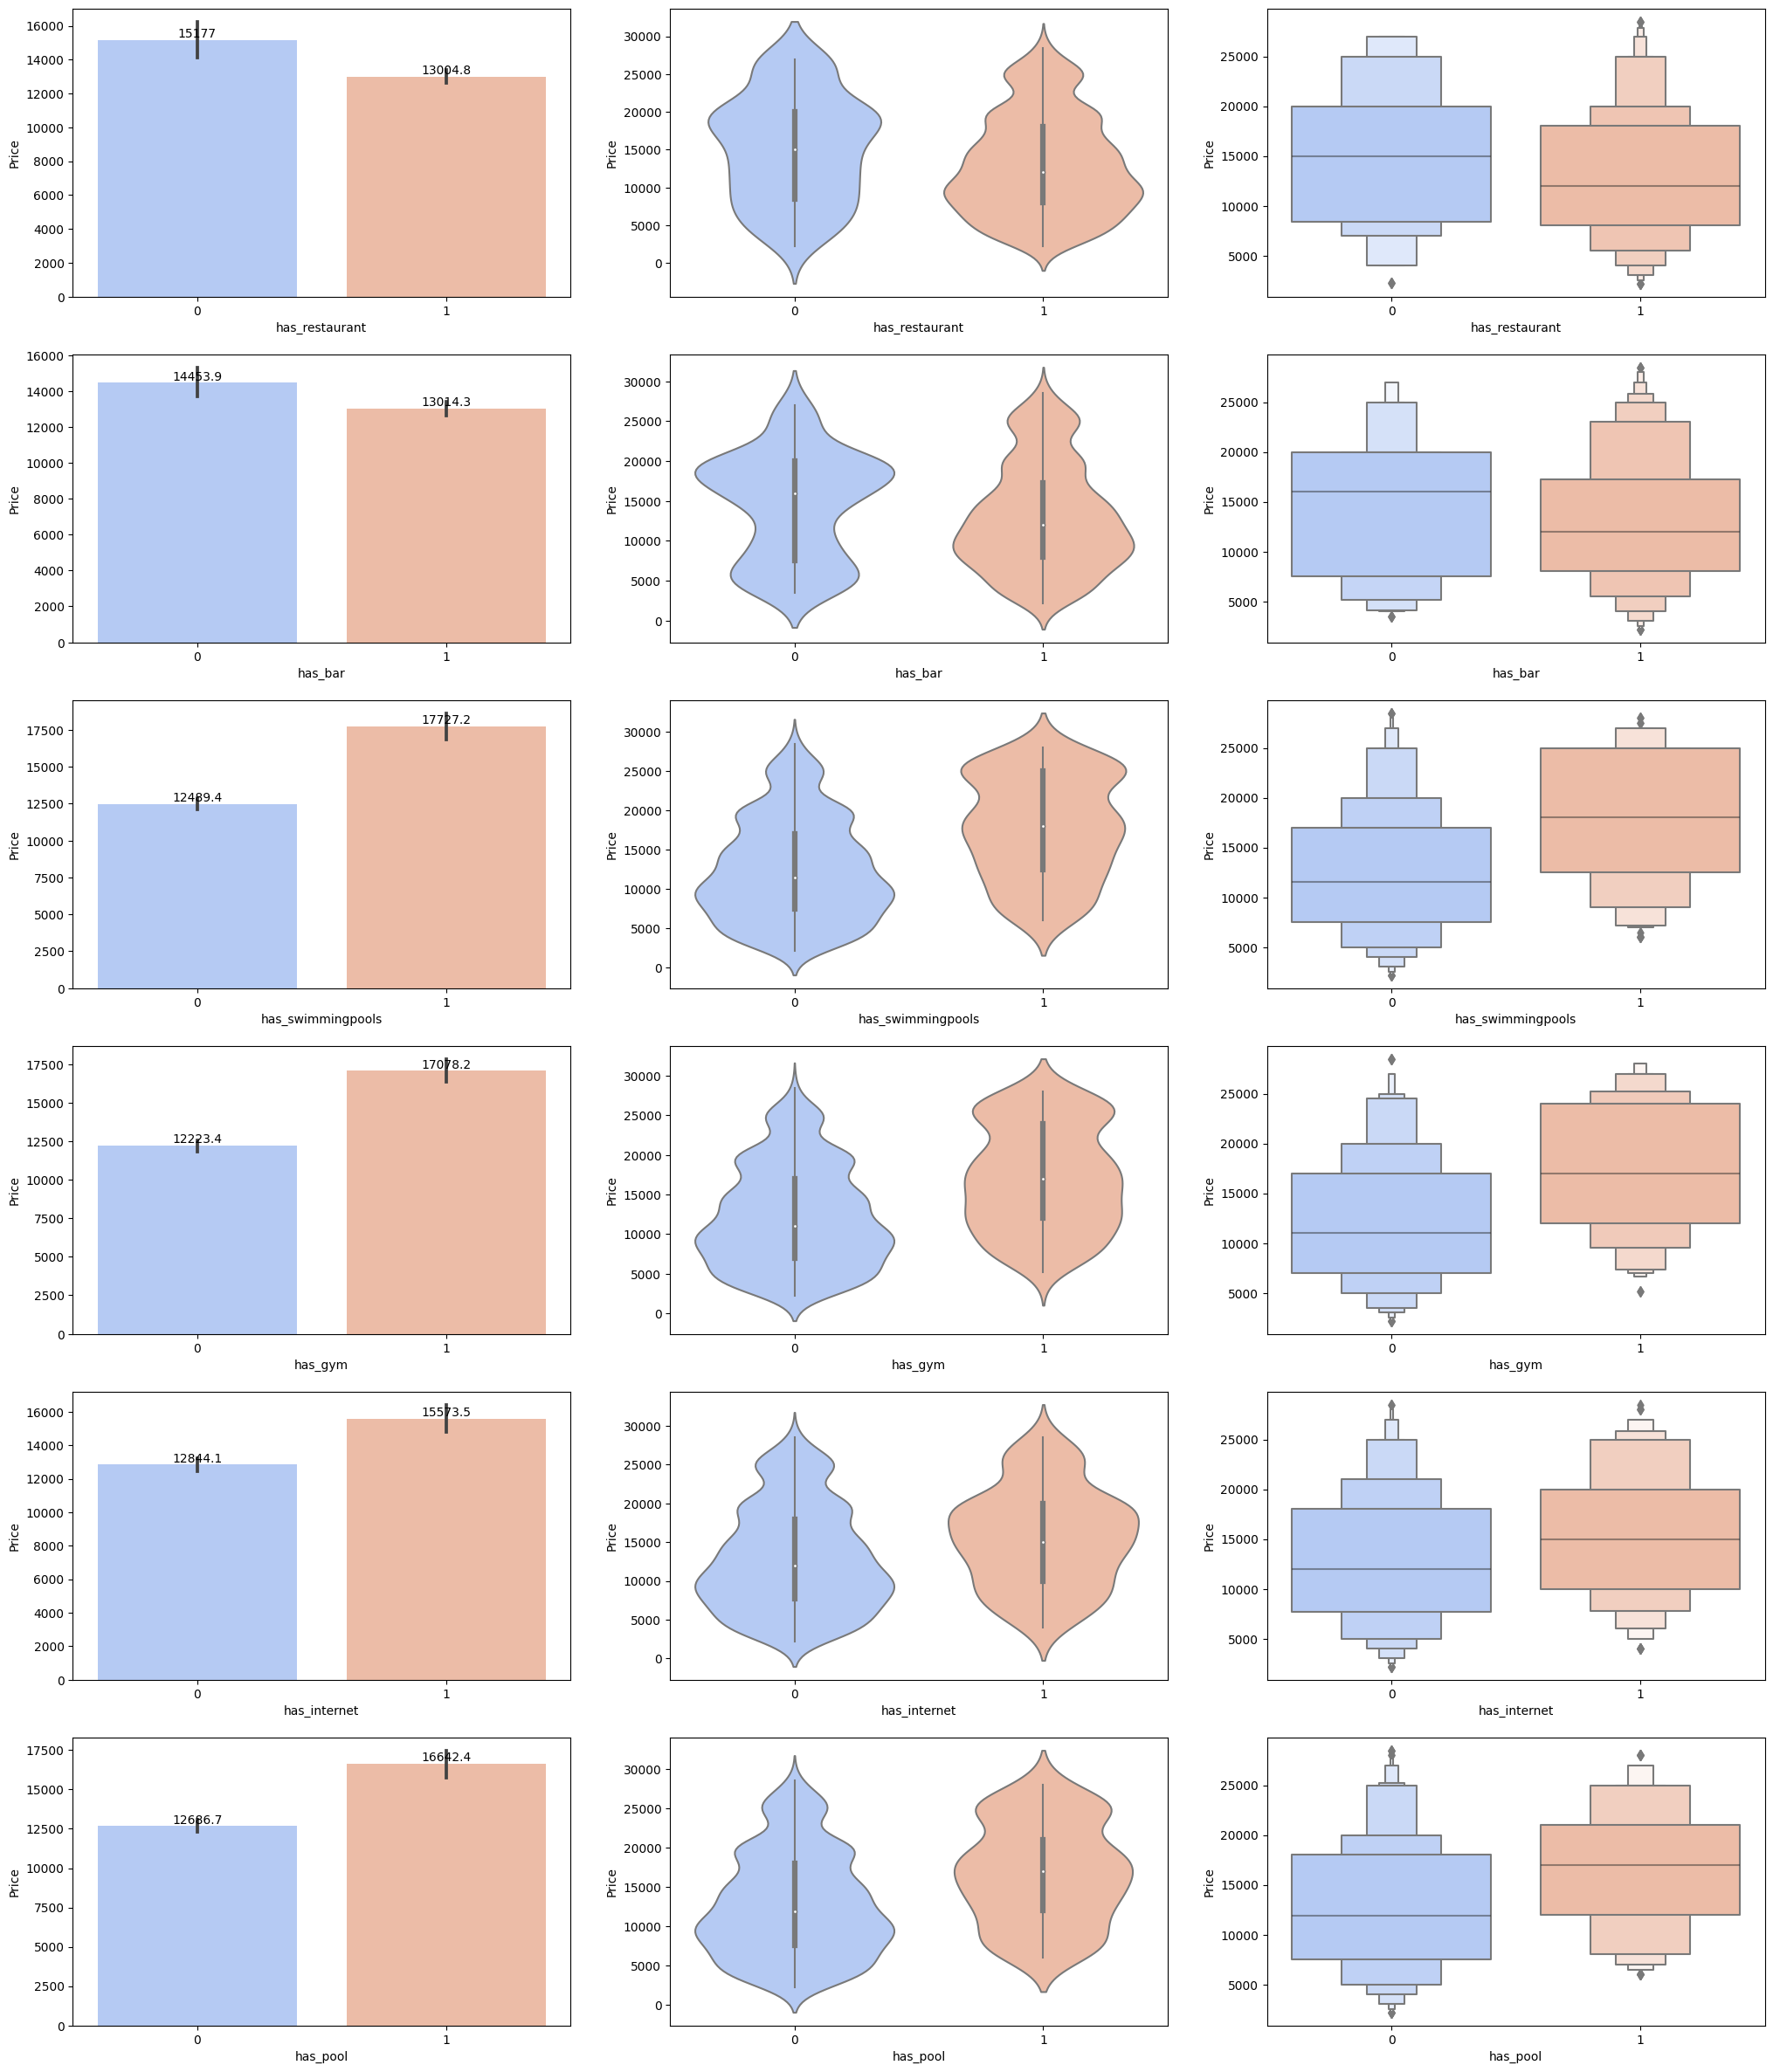

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(25, 30))

for i, col in enumerate(facilities_cols):
    bar = sns.barplot(data=lower_3000, y='Price', x=col, ax=ax[i, 0], palette="coolwarm")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=lower_3000, y='Price', x=col, ax=ax[i, 1], palette="coolwarm")
    sns.boxenplot(data=lower_3000,y="Price",x=col,ax=ax[i, 2], palette="coolwarm")

hotel yang harganya normal (30000 kebawah) ternyata harganya lebih dipengaruhi sama fasilitas sport atau rekreasi gitu kayak swimming pools, pool, sama gym

<Axes: xlabel='level_rating', ylabel='Price'>

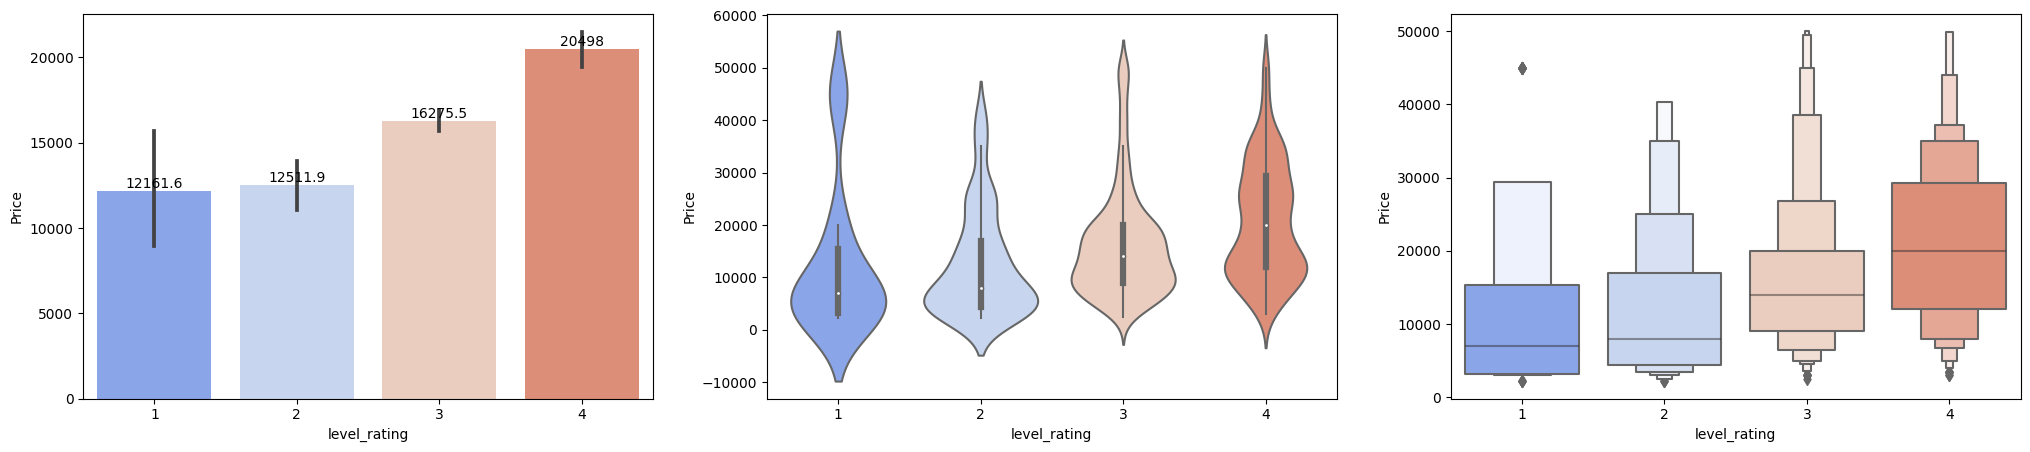

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

bar = sns.barplot(data=train, y='Price', x='level_rating', ax=ax[0], palette="coolwarm")
bar.bar_label(bar.containers[0])
sns.violinplot(data=train, y='Price', x='level_rating', ax=ax[1], palette="coolwarm")
sns.boxenplot(data=train,y="Price",x='level_rating',ax=ax[2], palette="coolwarm")

Dapat dilihat bahwa secara rata-rata semakin tinggi levelnya, maka harga akan cenderung tinggi juga

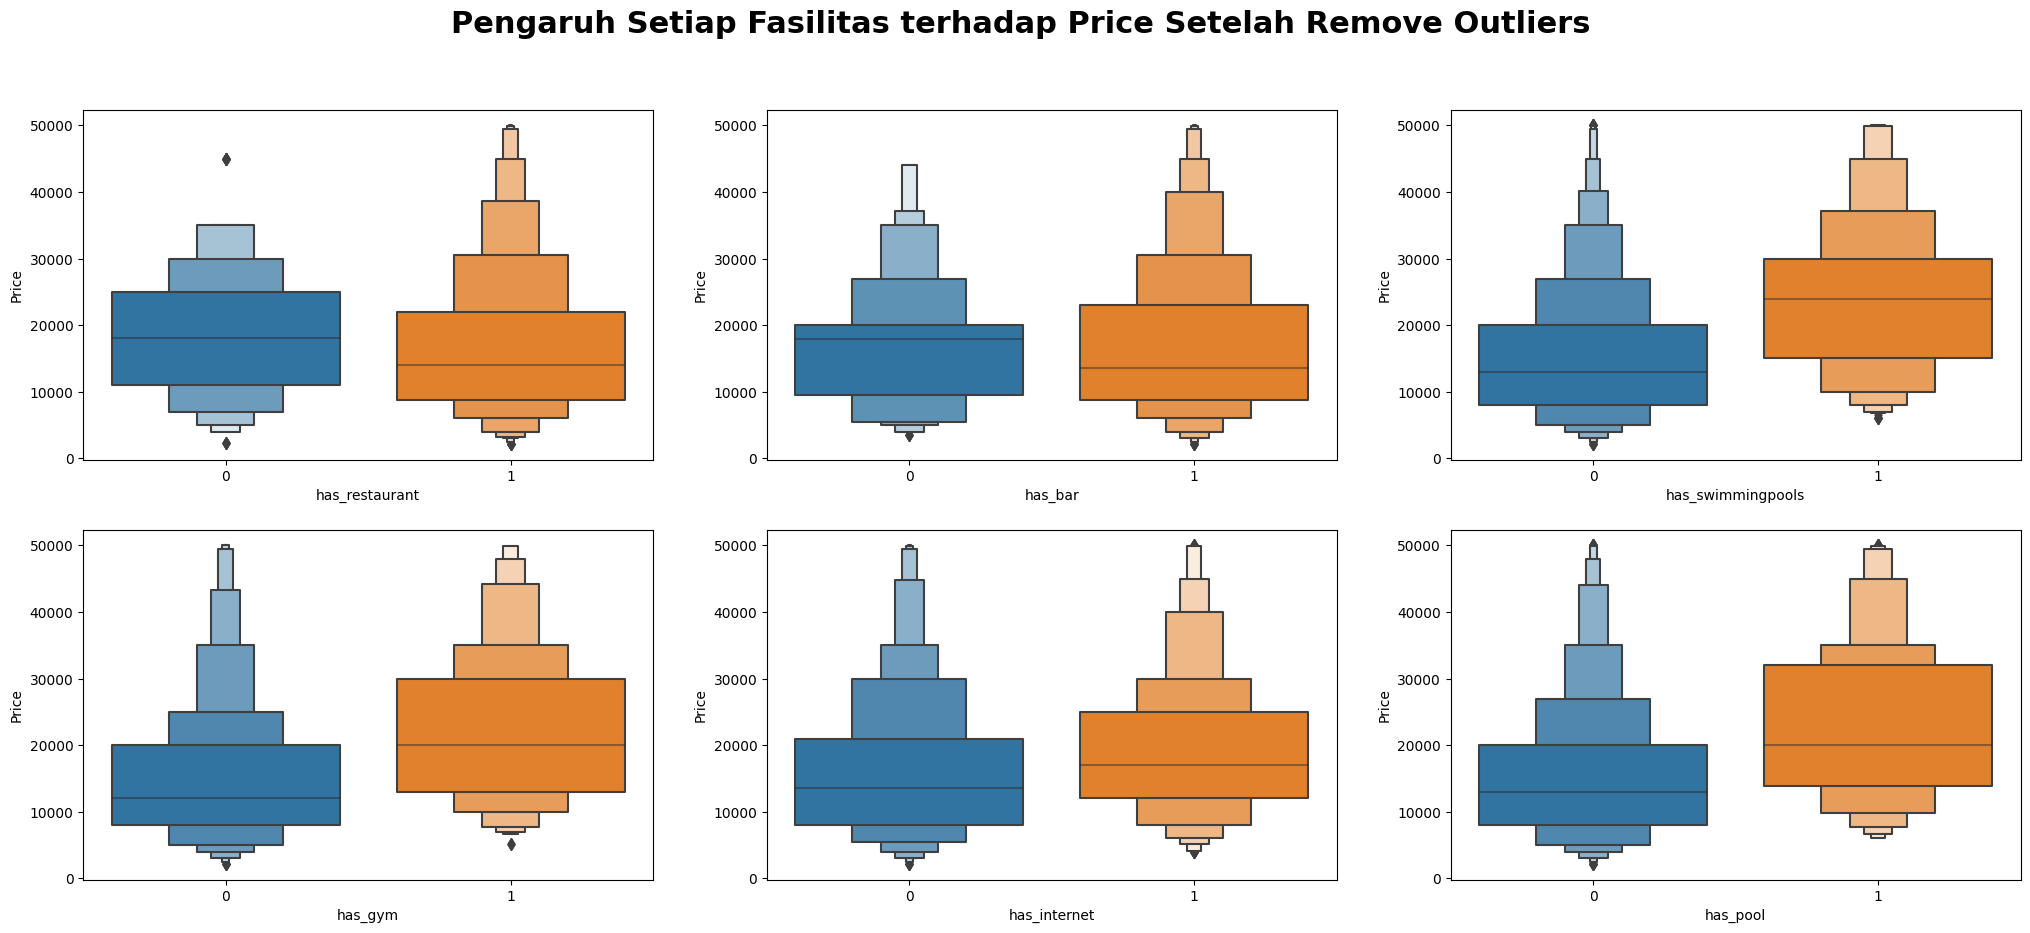

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
fig.suptitle("Pengaruh Setiap Fasilitas terhadap Price Setelah Remove Outliers",fontsize=22,fontweight='bold')

for i, col in enumerate(facilities_cols):
    # bar = sns.barplot(data=train, y='Price', x=col, ax=ax[i, 0], palette="coolwarm")
    # bar.bar_label(bar.containers[0])
    # sns.violinplot(data=train, y='Price', x=col, ax=ax[i, 1], palette="coolwarm")
    sns.boxenplot(data=train,y="Price",x=col,ax=ax[i//3, i%3])

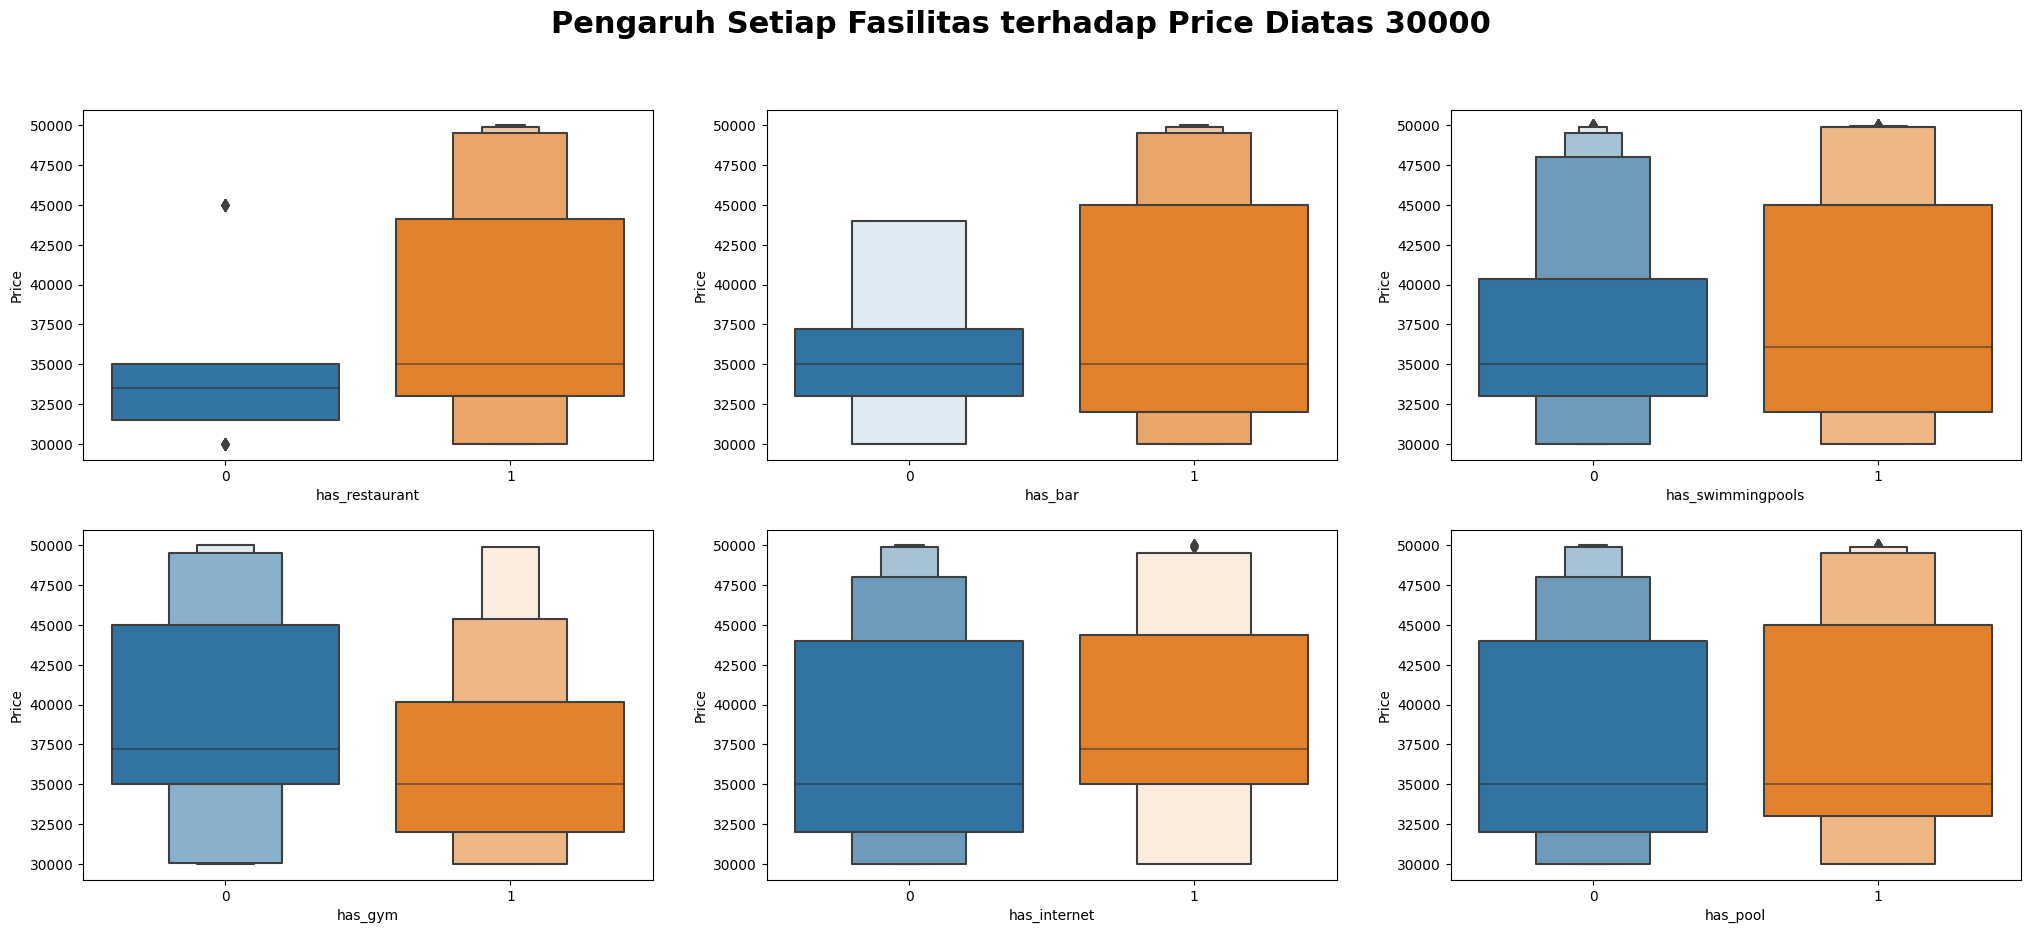

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
fig.suptitle("Pengaruh Setiap Fasilitas terhadap Price Diatas 30000",fontsize=22,fontweight='bold')

for i, col in enumerate(facilities_cols):
    # bar = sns.barplot(data=train, y='Price', x=col, ax=ax[i, 0], palette="coolwarm")
    # bar.bar_label(bar.containers[0])
    # sns.violinplot(data=train, y='Price', x=col, ax=ax[i, 1], palette="coolwarm")
    sns.boxenplot(data=greater_3000,y="Price",x=col,ax=ax[i//3, i%3])

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
fig.suptitle("Pengaruh Setiap Fasilitas terhadap Price Dibawah 30000",fontsize=22,fontweight='bold')

for i, col in enumerate(facilities_cols):
    # bar = sns.barplot(data=train, y='Price', x=col, ax=ax[i, 0], palette="coolwarm")
    # bar.bar_label(bar.containers[0])
    # sns.violinplot(data=train, y='Price', x=col, ax=ax[i, 1], palette="coolwarm")
    sns.boxenplot(data=lower_3000,y="Price",x=col,ax=ax[i//3, i%3])

<Axes: xlabel='facilities_count', ylabel='Price'>

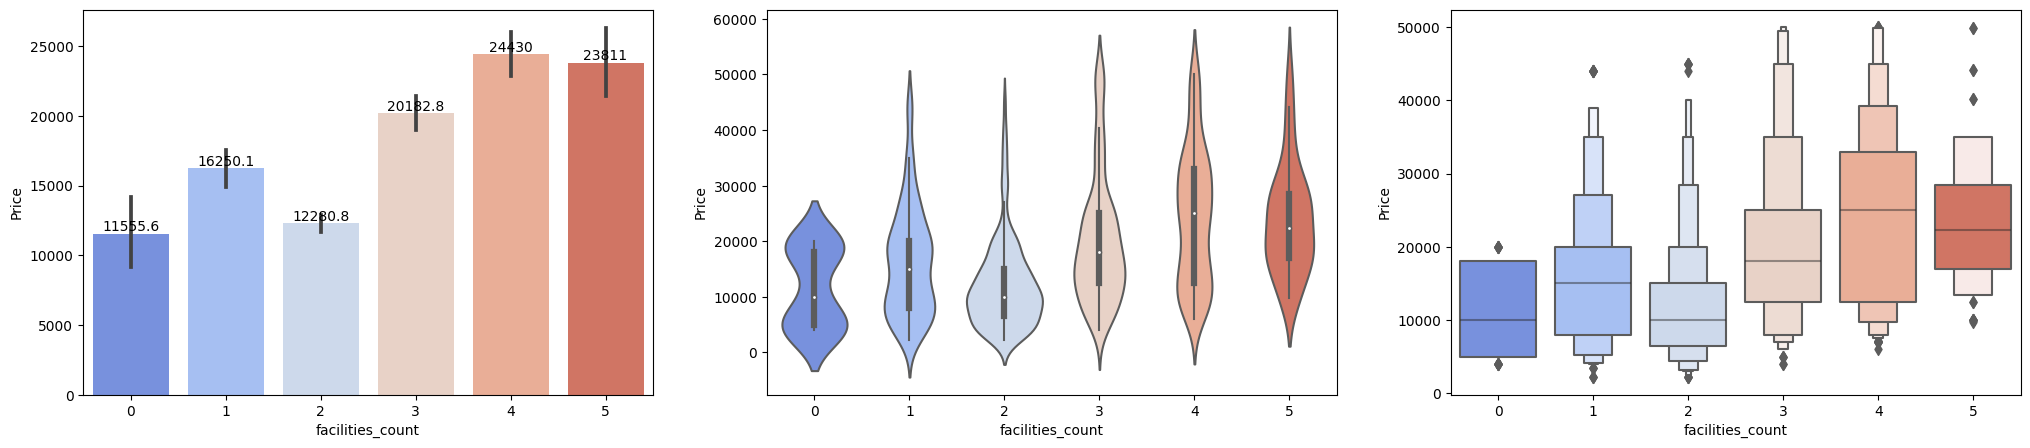

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

bar = sns.barplot(data=train, y='Price', x='facilities_count', ax=ax[0], palette="coolwarm")
bar.bar_label(bar.containers[0])
sns.violinplot(data=train, y='Price', x='facilities_count', ax=ax[1], palette="coolwarm")
sns.boxenplot(data=train,y="Price",x='facilities_count',ax=ax[2], palette="coolwarm")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.kdeplot(data=train,x='Price', hue='facilities_count', cut=0,ax=ax[0])
sns.boxenplot(data=train,x='facilities_count',y='Price',ax=ax[1])
fig.suptitle("Hubungan Jumlah Fasilitas dengan Price Setelah Remove Outliers",fontweight='bold')

Text(0.5, 0.98, 'Hubungan Jumlah Fasilitas dengan Price Setelah Remove Outliers')

In [ ]:
print("Untuk Insight di Infografis")
for facility in facilities_cols:
  train_facilities = train[train[facility]==1]
  print(f"{((train_facilities['Price'] > train['Price'].mean()).sum()/ train_facilities.shape[0] * 100):,.2f}% hotel yang memiliki {facility} berada diatas rata-rata")

Untuk Insight di Infografis
39.37% hotel yang memiliki has_restaurant berada diatas rata-rata
38.77% hotel yang memiliki has_bar berada diatas rata-rata
70.31% hotel yang memiliki has_swimmingpools berada diatas rata-rata
66.27% hotel yang memiliki has_gym berada diatas rata-rata
53.44% hotel yang memiliki has_internet berada diatas rata-rata
65.20% hotel yang memiliki has_pool berada diatas rata-rata


## EDA untuk Location

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

# bar = sns.barplot(data=train, y='Price', x='location', ax=ax[0], palette="coolwarm")
# bar.bar_label(bar.containers[0])
# sns.violinplot(data=train, y='Price', x='location', ax=ax[1], palette="coolwarm")
# sns.boxenplot(data=train,y="Price",x='location',ax=ax[2], palette="coolwarm")

Distribusi datanya seimbang, tidak ada yang dapat disimpulkan

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.lmplot(data=train, x='num_reviews', y='Price', aspect=2, height=4)
plt.title("Hubungan Jumlah Reviews terhadap Price Setelah Remove Outliers")

Text(0.5, 1.0, 'Hubungan Jumlah Reviews terhadap Price Setelah Remove Outliers')

Text(0.5, 1.0, 'Hubungan Rating Hotel terhadap Price Setelah Remove Outliers')

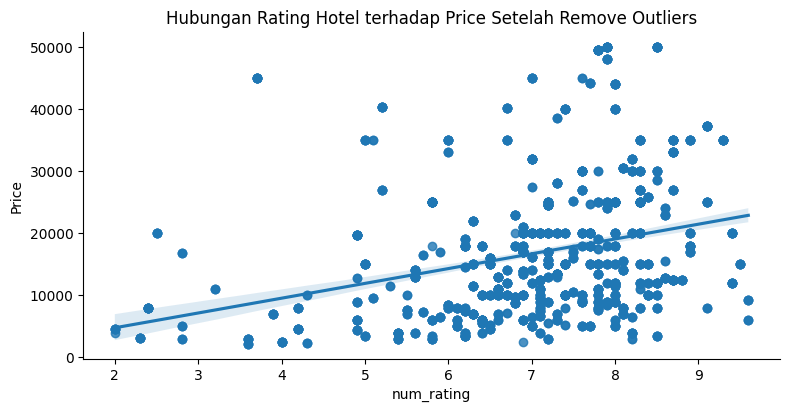

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.lmplot(data=train, x='num_rating', y='Price', aspect=2, height=4)
plt.title("Hubungan Rating Hotel terhadap Price Setelah Remove Outliers")

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(data=train, x='level_rating', palette="husl")

<Axes: xlabel='level_rating', ylabel='count'>

**Sampling**

In [ ]:
# # Define the parameters for sampling numerical feature
# numeric_cols = ["num_rating", "num_reviews", "rating_ratio", "facility_quality", "Price"]
# categorical_cols = ["facilities_count", "level_rating", "has_restaurant", "has_bar", "has_swimmingpools", "has_gym", "has_internet", "has_pool"]
# sample_size = 100 # Sampling jgn banyak"

# sample = pd.DataFrame()

# for col in numeric_cols:
#     numerical_mean = train[col].mean()
#     numerical_min = train[col].min()  # Minimum value for non-negative samples
#     numerical_max = train[col].max()
#     numerical_samples = np.random.uniform(numerical_min, numerical_max, size=sample_size)
#     sample[col] = numerical_samples

# # Define the categories and their corresponding probabilities for sampling categorical feature
# for col in categorical_cols:
#     categories = train[col].unique()
#     # Compute the value counts of the categorical column
#     value_counts = train[col].value_counts()
#     # Compute the probability distribution
#     probabilities = list(value_counts / value_counts.sum())
#     categorical_samples = np.random.choice(categories, size=sample_size, p=probabilities)
#     sample[col] = categorical_samples

# train = train[sorted(train.columns)]
# sample = sample[sorted(sample.columns)]
# test = test[sorted(test.columns)]

# train = pd.concat([train, sample])
# print(train.shape)

# sample.head()

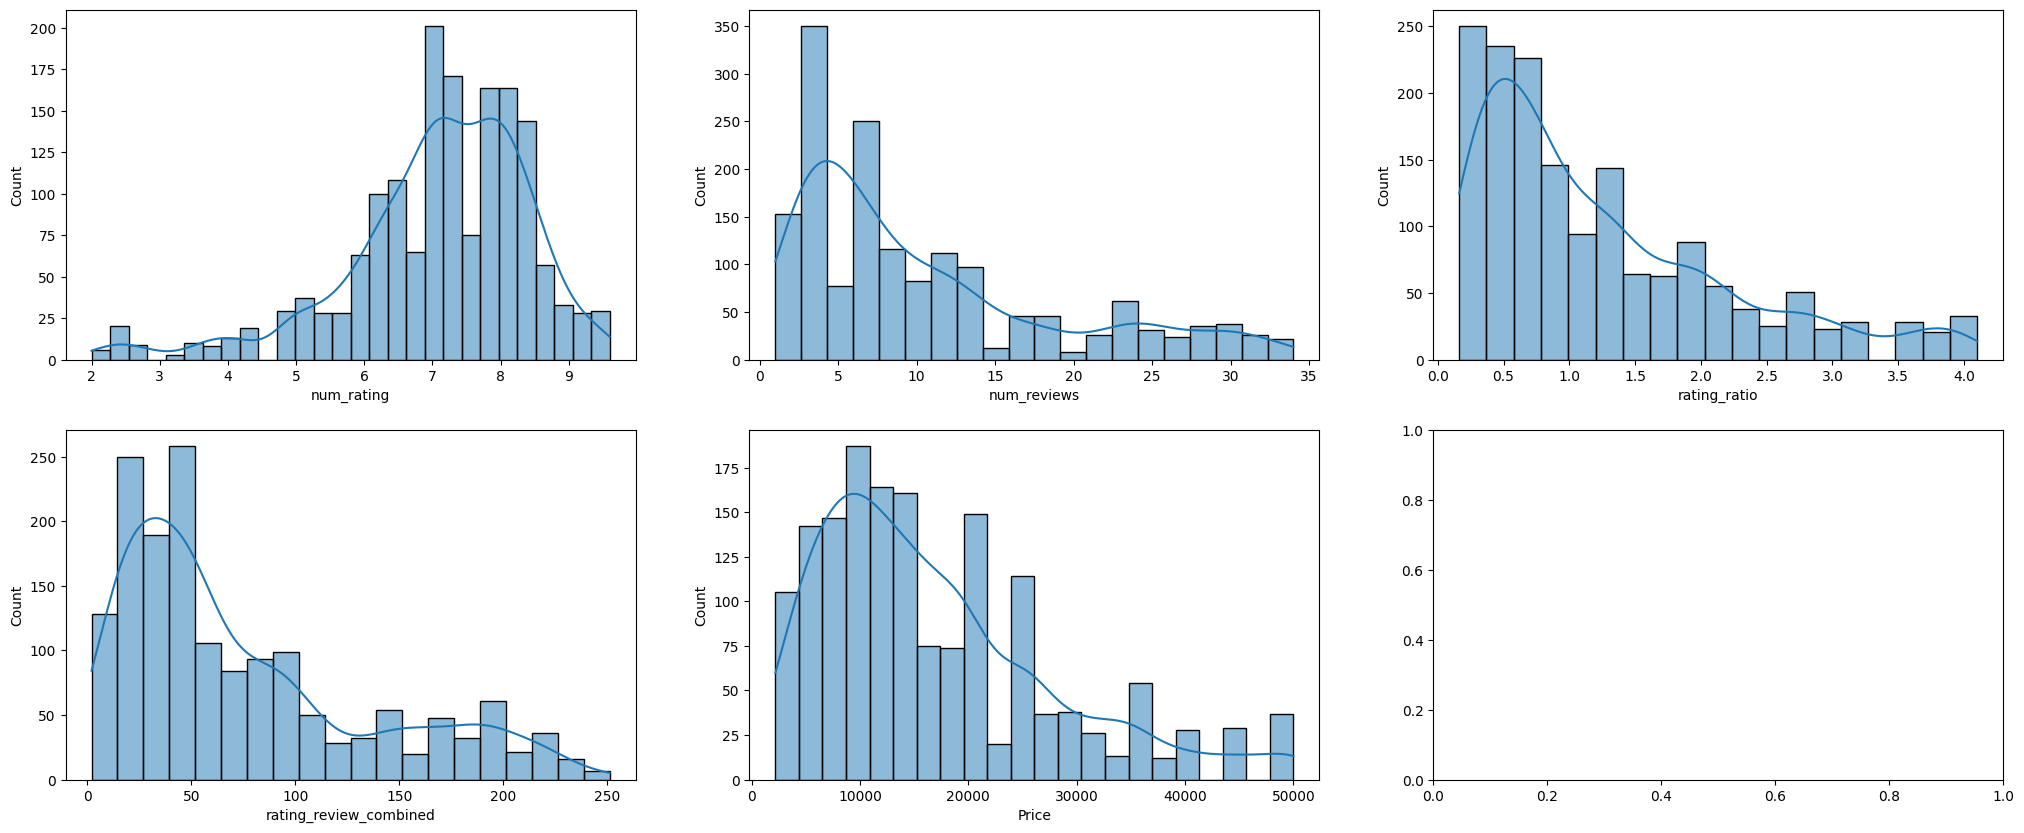

In [ ]:
# Select the numeric non categorical columns
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))

for i, col in enumerate(["num_rating", "num_reviews", "rating_ratio", "rating_review_combined", "Price"]):
    sns.histplot(data=train, x=col, ax=ax[i//3, i%3], kde=True)

### **Feature Scaling (Normalization)**

In [ ]:
# BOXCOX TF
# Not setting the lambda explicitly, you allow the boxcox function to determine the most appropriate transformation for the data
train.loc[:, "num_rating"] += 1.1 # To avoid -inf or 0
train["num_rating"],lambdaa = stats.boxcox(train["num_rating"])
test.loc[:, "num_rating"] += 1.1 # To avoid -inf or 0
test["num_rating"],lambda_test = stats.boxcox(test["num_rating"])

# MANUAL TF
train["num_reviews"] = np.sqrt(train["num_reviews"])
test["num_reviews"] = np.sqrt(test["num_reviews"])

train["rating_ratio"] = np.sqrt(train["rating_ratio"])
test["rating_ratio"] = np.sqrt(test["rating_ratio"])

train["rating_review_combined"] = np.sqrt(train["rating_review_combined"])
test["rating_review_combined"] = np.sqrt(test["rating_review_combined"])

# Distribution for non-binary columns
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))

for i, col in enumerate(["num_rating", "num_reviews", "rating_ratio", "rating_review_combined", "Price"]):
    sns.histplot(data=train, x=col, ax=ax[i//3, i%3], kde=True)

In [ ]:
lambda_test

1.5019669454621212

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.heatmap(train.corr(), annot=True)

<ipython-input-462-de1814957a60>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True)


<Axes: >

In [ ]:
# Check multicollinearity
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.heatmap(train.corr(), annot=True, mask=np.triu(train.corr()));

<ipython-input-463-1810ec6467bc>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot=True, mask=np.triu(train.corr()));


# **4. Modeling**

In [ ]:
# JANGAN DROP "rating_ratio", "num_rating"
# INI NAIKIN SKOR:
location_cols = ["location_Hallerson", "location_Machlessvile", "location_Stokol", "location_Uberlandia",
                 "location_Wanderland", "location_Willsmian", "location_Ubisville", "location_Andeman"]

for df in [train, test]:
    df.drop(["facilities", "rating", "has_bar", "has_internet",
             "facility_quality", "level_rating", "has_gym", "has_restaurant"] + location_cols, axis=1, inplace=True)

In [ ]:
train.columns

Index(['Price', 'has_swimmingpools', 'has_pool', 'num_rating', 'num_reviews',
       'rating_review_combined', 'rating_ratio', 'facilities_count'],
      dtype='object')

In [ ]:
# Membuat estimator untuk stacking model
estimators = [
    ('linear', LinearRegression()),
    ('lasso', LassoCV()),
    ('ridge', RidgeCV())
]

models = {
    'linear_regression': LinearRegression(positive=True),
    'lasso': LassoCV(random_state=42),
    'ridge': RidgeCV(),
    'bayesian_ridge': BayesianRidge(),
    # "stacking_model": StackingRegressor(estimators=estimators, final_estimator=LassoCV(random_state=42)) # Banyak text error
    'elastic_net': ElasticNet(),
    # 'randomforest': ensemble.RandomForestRegressor(random_state=42),
    'xgboost': xgb.XGBRegressor(random_state=42),
}

In [ ]:
# Function for performing k-fold cross-validation
def kfold_cv(model, X, y):
    # n_splits makin besar -> SKOR MAKIN BAGUS (awas overfit)
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    scores = []
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        predictions = model.predict(X_val)

        mae_score = mae(y_val, predictions)
        scores.append(mae_score)
    return np.mean(scores)

# Prepare the input features and target variables
train_copy = train.copy()

X = train_copy.drop(["Price"], axis=1)
y = train_copy.pop("Price")
# y_log = np.log(y)

In [ ]:
for name, model in models.items():
    score = kfold_cv(model, X, y)
    print(f"{name}: {score}")

linear_regression: 6937.045788143604
lasso: 7013.031600362822
ridge: 6943.482354675764
bayesian_ridge: 6939.734217040571
elastic_net: 7362.28601655009
xgboost: 825.0717744597792


In [ ]:
def learn_curve(X, y, model):
    cv_scores = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=10)

    model.fit(X, y)
    train_score = mae(y, model.predict(X))

    train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X, y=y, cv=10, scoring="neg_mean_absolute_error", random_state=42)
    train_scores = -np.mean(train_scores, axis=1)
    test_scores = -np.mean(test_scores, axis=1)

    lc = pd.DataFrame({"Training_size": train_sizes, "Training_loss": train_scores, "Validation_loss": test_scores}).melt(id_vars="Training_size")
    return {"cv_scores": cv_scores,
            "train_score": train_score,
            "learning_curve": lc}

In [ ]:
# Dapat key dari dict dari value
def get_key_from_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None  # Value not found

In [ ]:
# Learning curve
fig,ax = plt.subplots(3, 3, figsize=(35, 28))

r = c = 0
for n, model in enumerate(models.values()):
    lc = learn_curve(X, y, model)
    # Min-max scaler
    scaler = MinMaxScaler()
    lc["learning_curve"]["value"] = scaler.fit_transform(np.array([lc["learning_curve"]["value"]]).reshape(-1, 1))
    sns.lineplot(data=lc["learning_curve"], x="Training_size", y="value", hue="variable", ax=ax[r,c])
    ax[r, c].set_title(f'Model: {get_key_from_value(models, model)}\nTraining Accuracy: {lc["train_score"]:.1f}\nValidation Accuracy: {np.mean(lc["cv_scores"]):.1f}')
    ax[r, c].set_ylabel("MAE")
    c += 1
    if (n+1)%3 == 0:
        c = 0
        r += 1

plt.show()

LINREG MAYAN UNDERFIT

XGBOOST OVERFIT

Learning curve of a good fit model has a moderately high training loss at the beginning which gradually lowers upon adding training examples and flattens gradually indicating addition of more training examples doesn't improve the model performance on training data.

Learning curve of a good fit model has a HIGH validation loss at the beginning which gradually lowers upon adding training examples and flattens gradually indicating addition of more training examples doesn't improve the model performance on unseen data

Good:
- Train and Validation loss close to each other with validation loss > training loss.
- Initially reducing training and validation loss and a pretty flat training and validation loss after some point

Overfit:
- Train and Validation loss far away from each other.
- Gradually decreasing validation loss (without flattening)
- Very low training loss that's very slightly increasing

Underfit:
- Increasing Training Loss.
- Training and Validation Loss very close to each other at the end
- Sudden dip in the training and validation losses at the end

### **Feature Selecting LassoCV**

In [ ]:
model = LassoCV(random_state=42)
model.fit(X, y)

coefficients = model.coef_
feature_importance = abs(coefficients)

# Create a dictionary to map feature names to importance values
feature_importance_dict = dict(zip(X.columns, feature_importance))

# Sort the feature importance in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

has_swimmingpools: 6029.175297482468
has_pool: 5472.453403935426
facilities_count: 1253.2260046911836
rating_review_combined: 527.6837372834561
num_rating: 44.96604886713373
num_reviews: 0.0
rating_ratio: 0.0


Meskipun rating_ratio = 0.0 -> JANGAN DIDROP

In [ ]:
# LASSO (1) & LINREG (2) BAGUS!
# model = linear_model.LinearRegression(positive=True)

lasso_param = {'eps': 0.00011047090960385867, 'tol': 0.009464039687858888, 'n_alphas': 57, 'max_iter': 6344}

model = LassoCV(random_state=42)
model.fit(X, y)

score = kfold_cv(model, X, y)
print("Model hasil parameter tuning", score)

Model hasil parameter tuning 7013.031600362822


In [ ]:
# Create a DataFrame for the submission
submission = pd.DataFrame({
    "ID": test.index,  # Use the respondent IDs from the test data
    "Price": model.predict(test)
})
# Save the submission DataFrame to a CSV file without including the index
# submission.iloc[682,1] = submission.iloc[682,1] * -1
submission.to_csv("submission.csv", index=False)
submission.loc[submission["Price"] <= 0]

Empty DataFrame
Columns: [ID, Price]
Index: []

In [ ]:
submission.describe()

ID         Price
count  767.000000    767.000000
mean   383.000000  16196.144251
std    221.558119   2986.080115
min      0.000000   4748.014103
25%    191.500000  14252.018360
50%    383.000000  16705.524847
75%    574.500000  18506.671310
max    766.000000  22587.770653

In [ ]:
submission.head()

ID         Price
0   0  14643.797004
1   1  18363.212173
2   2  11176.250578
3   3  19030.450921
4   4  12349.110252

In [ ]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import joblib
export_model = LassoCV(random_state=42)
export_model.fit(X,y)
joblib.dump(export_model, 'model.pkl')

['model.pkl']

<hr><hr>

In [ ]:
-------

SyntaxError: ignored

# **Hyperparameter Tuning**

In [ ]:
# xgb_param = {'learning_rate': 0.2401553821503166, 'max_bin': 23, 'grow_policy': 'depthwise',
#              'max_depth': 10, 'subsample': 0.8850668242862957, 'colsample_bytree': 0.6061224941941191,
#              'gamma': 0.5709605034935871, 'min_child_weight': 1, 'reg_alpha': 0.9112761028777343,
#              'reg_lambda': 0.28815644263864515, 'n_estimators': 800}

# ridge_params = {'alphas': 0.011343950532580206,
#  'gcv_mode': 'svd',
#  'fit_intercept': True,
#  'alpha_per_target': False}

In [ ]:
# Function for tuning a model using k-fold cross-validation
def tune_kfold_cv(model, X, y, metric, n_folds=8):
    # Create a k-fold cross-validation object with specified number of folds
    skfold = KFold(n_splits=n_folds, random_state=0, shuffle=True)

    # List to store the scores obtained from each fold
    scores = []

    # Iterate over the folds
    for train_index, test_index in skfold.split(X, y):
        # Split the data into training and testing sets based on the fold indices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the model on the training data and evaluate it on the testing data
        model.fit(X_train, y_train)
        predictions = model.predict(X_test.values)

        # Calculate the score using the specified evaluation metric
        score = metric((y_test), (predictions))

        # Append the score to the list of scores
        scores.append(score)

        # Print the MAE score for the current fold
        print(f'MAE: {score:.3f}')

    # Return the list of scores
    return scores

In [ ]:
X

In [ ]:
# Objective function for hyperparameter optimization using Optuna
def objective(trial, data=X, target=y):
    # Define the hyperparameter search space using trial suggestions
    params = {
        'eps' : trial.suggest_float('eps', 1e-4, 1e-1),
        'tol' : trial.suggest_float('tol', 1e-4, 1e-1),
        # 'alphas' : [0.01,0.001,0.1],
        'n_alphas' : trial.suggest_int('n_alphas', 50,1000),
        'max_iter' : trial.suggest_int('max_iter', 1000,10000),
    }

    # Create a CatBoostClassifier with the suggested hyperparameters
    model = linear_model.LassoCV(**params)

    # Perform k-fold cross-validation with the tuned model and calculate the average score
    scores = tune_kfold_cv(model, X, y, mae, 8)
    return np.sum(scores) / 8

In [ ]:
# Create an Optuna study with the direction set to maximize
study = optuna.create_study(direction='minimize')

# Run the optimization process using the objective function defined earlier, with a specified number of trials
study.optimize(objective, n_trials=100)

# Print the number of finished trials (i.e., the number of trials that have been executed)
print('Number of finished trials:', len(study.trials))

# Print the best trial's parameters, which correspond to the set of hyperparameters that yielded the highest objective value
print('Best trial:', study.best_trial.params)

In [ ]:
# Assign the best parameters found during optimization to a variable
parameter_tuned = study.best_trial.params

# Create a CatBoostClassifier model using the best parameters
model = linear_model.RidgeCV(**parameter_tuned)
score = kfold_cv(model, X, y)
print("Model hasil parameter tuning", score)

In [ ]:
parameter_tuned